# Music Source Separation with Deep Learning

**Authors:** Afshinrad, Magalini, Manattini, Montanari  
**Course:** Selected Topics for Music and Acoustic Engineering  
**Date:** June 2025

---

**Project Overview :**

This notebook implements and compares state-of-the-art music source separation techniques using both classical signal processing approches and deep learning models. We explore various neural network architectures including U-Net, Demucs, and custom hybrid models to separate individual instruments (vocals, drums, bass, other) from mixed audio recordings.

**Objectives :**

- Implement multiple source separation architectures
- Compare performance using standard metrics (SDR, SIR, SAR)
- Evaluate on the MUSDB18 dataset
- Analyze the trade-offs between model complexity and separation quality

**Technologies Used :**

- **Deep Learning:** PyTorch
- **Audio Processing:** librosa, torchaudio
- **Dataset:** MUSDB18HQ
- **Evaluation:** mir_eval, custom metrics

---

## Install Requirements

In [3]:
%pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
Note: you may need to restart the kernel to use updated packages.


In [4]:
import IPython.display as ipd
import torch
import torchaudio
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy
import shutil
from sklearn.decomposition import NMF
import warnings
from mir_eval.separation import bss_eval_sources


warnings.filterwarnings('ignore')


## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [5]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed" # trimmed dataset will be saved here

In [6]:
# load the first song and get the sample rate
def load_first_song():
    song = next(os.walk(DATASET_FOLDER))[1][0]
    audio_path = os.path.join(DATASET_FOLDER, song, "mixture.wav")
    audio, sample_rate = torchaudio.load(audio_path)
    return audio, sample_rate

_, sample_rate = load_first_song()

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [7]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict


def load_dataset():
    """
    Load the dataset from the DATASET_FOLDER_TRIMMED folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm(os.listdir(DATASET_FOLDER_TRIMMED)):
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the DATASET_FOLDER_TRIMMED folder.
    It processes each track folder, saves the stems as individual files,
    and generates a new_mixture file as the sum of the stems.
    Args:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    Returns:
        None
    """
    for track_folder, stems_dict in tqdm(dataset_dict.items()):
    
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform

        # make the new_mixture the same loudness as the original mixture
        if "mixture" in stems_dict:
            original_mixture = stems_dict["mixture"]

            # Scale the new mixture to match the volume of the original mixture
            original_max_value = torch.max(torch.abs(original_mixture))
            new_max_value = torch.max(torch.abs(new_mixture))
            if new_max_value > 0:
                new_mixture *= (original_max_value / new_max_value)
        else:
            # If there is no original mixture, just normalize the new_mixture
            new_mixture = new_mixture / torch.max(torch.abs(new_mixture))


        # Raise an error if the new_mixture is not normalized
        if torch.max(torch.abs(new_mixture)) > 1:
            # delete dataset folder if error occurs
            if os.path.isdir(DATASET_FOLDER_TRIMMED):
                print(f"Deleting dataset folder {DATASET_FOLDER_TRIMMED} due to error.")
                shutil.rmtree(DATASET_FOLDER_TRIMMED)

            raise ValueError(f"new_mixture for {track_folder} is not normalized. Max value: {torch.max(torch.abs(new_mixture))}")
        
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")


def load_or_create_trimmed_dataset():
    """
    Load or create the trimmed dataset.
    If the dataset already exists, it loads the dataset from the musdb18hq_trimmed folder.
    If the dataset does not exist, it processes the musdb18hq/test folder and saves the trimmed dataset.
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    # Check if the trimmed dataset already exists
    if os.path.isdir(DATASET_FOLDER_TRIMMED):
        print("Dataset already exists.")

        # Load the trimmed dataset
        dataset_dict = load_dataset()
        print("Dataset loaded.")
    else:
        print("Loading dataset...")
        dataset_dict = load_and_process_dataset()
        print("Dataset loaded.")
    
        # Save the trimmed dataset
        os.makedirs(DATASET_FOLDER_TRIMMED, exist_ok=True)
        create_dataset(dataset_dict)

        print("Trimmed dataset saved.")
    
    return dataset_dict

Save the new DATASET FOLDER

In [8]:
dataset_dict = load_or_create_trimmed_dataset()

Dataset already exists.


100%|██████████| 50/50 [00:00<00:00, 74.24it/s]

Dataset loaded.


Trimmed tracks check

In [9]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
def print_stem_shapes(first_track_folder):
    for stem_name in dataset_dict[first_track_folder].keys():
        print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")

print_stem_shapes(first_track_folder)


Number of keys in dataset_dict: 50
First track folder: Moosmusic - Big Dummy Shake
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


## Traditional approaches

A classical digital signal processing approach that combines multiple techniques for audio source separation without machine learning.


### Function Overview: `separate_sources_HPSS_REPET`

##### 1. **Initial HPSS Decomposition**
- Uses **Harmonic-Percussive Source Separation** to split the mixture into:
  - **Harmonic component**: Captures tonal/pitched content (vocals, bass, other instruments)
  - **Percussive component**: Emphasizes transient, drum-like features

##### 2. **Drums Extraction (Enhanced HPSS)**
- Starts with percussive component from HPSS
- **Vocal frequency cleaning**: Attenuates 300-3000 Hz range to remove vocal bleed
- Applies attenuation factor (0.4) to reduce vocal artifacts in drum track
- Reconstructs cleaned drum signal using original phase

##### 3. **Bass Extraction (Low-pass Filtering)**
- Applies Butterworth low-pass filter to harmonic component
- **Cutoff frequency**: 200 Hz (captures fundamental bass frequencies)
- **Filter order**: 4th order for sharp frequency rolloff

##### 4. **Vocals Extraction (REPET-SIM)**
- Uses **nearest-neighbor filtering** on harmonic component
- **Repeating pattern removal**: Identifies and removes instrumental patterns
- **Cosine similarity**: Compares spectral frames over 2-second windows
- **Vocal isolation**: Extracts non-repetitive content (vocals) from repetitive background

##### 5. **Other Component (Subtractive)**
- Calculates residual: `y_other = y_mixture - y_drums - y_bass - y_vocals`
- Captures remaining instruments and ambient sounds

#### Key Features
- **No training required**: Uses classical DSP techniques
- **Real-time capable**: Computationally efficient
- **Frequency-aware**: Each method targets appropriate frequency ranges
- **Artifact reduction**: Includes vocal cleaning step for drums
- **Visualization**: Generates spectrograms for each separated component

Compute the spectrogram and phases for each tracks


In [10]:
def separate_sources_HPSS_REPET( 
    y,
    sr=sample_rate,
    hpss_margin=1.0, 
    hpss_power=2.0,
    # Parameters for cleaning drums from vocal residues
    drum_clean_vocal_freq_min=300.0,  # Hz, start of vocal range to attenuate
    drum_clean_vocal_freq_max=3000.0,  # Hz, end of vocal range to attenuate
    drum_clean_vocal_atten_factor=0.4, # Attenuation factor (0.0 = mute, 1.0 = no change)
    # Parameters for bass
    bass_cutoff=200.0,
    bass_order=4,
    # Parameters for main vocal separation
    nn_width_vocals_sec=2.0 # Increased for better vocal separation
):
    """
    Separate sources from a mixture audio file using HPSS and NMF-based vocal separation.
    Args:
        y (np.ndarray): Mixture audio signal.
        sr (int, optional): Sample rate for loading the audio. If None, uses the file's sample rate.
        hpss_margin (float): Margin for HPSS separation.
        hpss_power (float): Power for HPSS separation.
        drum_clean_vocal_freq_min (float): Minimum frequency to attenuate in drums to clean vocal residues.
        drum_clean_vocal_freq_max (float): Maximum frequency to attenuate in drums to clean vocal residues.
        drum_clean_vocal_atten_factor (float): Factor by which to attenuate the specified frequency range in drums.
        bass_cutoff (float): Cutoff frequency for low-pass filter to extract bass.
        bass_order (int): Order of the low-pass filter for bass extraction.
        nn_width_vocals_sec (float): Width of the non-negative matrix factorization filter for vocals in seconds.
    Returns:
        dict: A dictionary containing separated audio sources: 'drums', 'bass', 'vocals', 'other'.
    """
    # Ensure the input is a numpy array
    if y.ndim > 1:
        y = librosa.to_mono(y)

    # 2) HPSS for initial extraction of drums and harmonic component
    # Compute STFT of the original mix
    D_mixture = librosa.stft(y)
    n_fft = (D_mixture.shape[0] - 1) * 2 # Infer n_fft from the spectrogram

    D_harmonic_mixture, D_percussive_mixture = librosa.decompose.hpss(
        D_mixture, 
        margin=hpss_margin, 
        power=hpss_power
    )

    # General harmonic component (will be used for bass and vocals)
    y_harmonic_overall = librosa.istft(D_harmonic_mixture, length=len(y))

    # --- 3) Cleaning Drums from Vocal Residues ---
    # Start from D_percussive_mixture (the drum spectrogram from HPSS)
    D_perc_mag, D_perc_phase = librosa.magphase(D_percussive_mixture)

    # Create a copy of the magnitude for modification
    D_perc_mag_cleaned = np.copy(D_perc_mag)

    # Get the frequencies corresponding to the STFT bins
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Apply attenuation in the defined vocal frequency range
    for i, freq_bin in enumerate(frequencies):
        if drum_clean_vocal_freq_min <= freq_bin <= drum_clean_vocal_freq_max:
            D_perc_mag_cleaned[i, :] *= drum_clean_vocal_atten_factor

    # Reconstruct the cleaned drum spectrogram
    D_drums_cleaned_stft = D_perc_mag_cleaned * D_perc_phase
    y_drums = librosa.istft(D_drums_cleaned_stft, length=len(y))

    # --- 4) Extraction of Bass from the General Harmonic Component ---
    # Apply a low-pass filter to y_harmonic_overall
    nyquist = 0.5 * sr
    # Ensure bass_cutoff is below the Nyquist frequency
    actual_bass_cutoff = min(bass_cutoff, nyquist - 1) # -1 for safety
    if actual_bass_cutoff <= 0:
        print(f"Warning: bass_cutoff ({bass_cutoff} Hz) is not valid with sr={sr} Hz. Bass will not be filtered.")
        y_bass = np.zeros_like(y_harmonic_overall) # or handle differently
    else:
        b, a = scipy.signal.butter(bass_order, actual_bass_cutoff / nyquist, btype='low', analog=False)
        y_bass = scipy.signal.lfilter(b, a, y_harmonic_overall)

    # --- 5) Extraction of Vocals from the General Harmonic Component ---
    # Note: for better separation, one could subtract the estimated bass
    # from y_harmonic_overall before looking for vocals, but for simplicity we use y_harmonic_overall.
    # y_harmonic_minus_bass = y_harmonic_overall - y_bass # Optional, could help

    S_harmonic_overall, phase_harmonic_overall = librosa.magphase(librosa.stft(y_harmonic_overall)) # or from y_harmonic_minus_bass
    
    width_vocals_frames = int(librosa.time_to_frames(nn_width_vocals_sec, sr=sr, n_fft=n_fft))
    
    S_instrumental_repeating = librosa.decompose.nn_filter(
        S_harmonic_overall, 
        aggregate=np.median, 
        metric='cosine', 
        width=width_vocals_frames
    )

    # The mask for vocals is what is NOT repetitive in the harmonic component
    S_vocals_mag = np.clip(S_harmonic_overall - S_instrumental_repeating, 0, None)
    
    y_vocals = librosa.istft(S_vocals_mag * phase_harmonic_overall, length=len(y))

    # --- 6) Calculation of the "Other" Residual ---
    # Subtract the estimated components from the original mix
    y_other = y - y_drums - y_bass - y_vocals


    return {
        'drums': y_drums,
        'bass': y_bass,
        'vocals': y_vocals,
        'other': y_other
    }

In [11]:
def compute_bss_eval(ref_sources, est_sources):
    """
    Compute BSS evaluation metrics (SDR, SIR, SAR) for the given reference and estimated sources.
    Args:
        ref_sources (list): List of reference source waveforms.
        est_sources (list): List of estimated source waveforms.
    Returns:
        tuple: SDR, SIR, SAR values.
    """
    sdr, sir, sar, _ = bss_eval_sources(np.array(ref_sources), np.array(est_sources))
    return sdr, sir, sar

In [12]:
def evaluate_metrics_across_dataset(separate_sources, dataset_dict, sample_rate, verbose=False):
    """
    Evaluate SDR, SIR, and SAR metrics across the dataset.
    Args:
        separate_sources (function): Function to separate sources from a mixture.
        dataset_dict (dict): Dictionary containing the dataset with track names as keys and stem waveforms as values.
        sample_rate (int): Sample rate of the audio files.
        verbose (bool): If True, prints detailed information during processing.
    Returns:
        tuple: SDR, SIR, SAR collections for each stem.
    """

    source_names = ["bass", "drums", "vocals", "other"]
    
    sdr_results = {stem: [] for stem in source_names}
    sar_results = {stem: [] for stem in source_names}
    sir_results = {stem: [] for stem in source_names}

    sdr_results_list = []
    sar_results_list = []
    sir_results_list = []

    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if verbose:
            print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            if verbose:
                print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].unsqueeze(0)  # Add batch dimension
        # convert to numpy
        mixture = mixture.detach().cpu().numpy()
        
        # Perform source separation
        separated_sources = separate_sources(mixture)

        # Extract reference sources from stems_dict
        ref_sources = [stems_dict[stem].numpy() for stem in source_names]
        est_sources = [separated_sources[stem] for stem in source_names]

        # Convert reference sources to mono
        ref_sources = [librosa.to_mono(source) if source.ndim > 1 else source for source in ref_sources]
        est_sources = [librosa.to_mono(source) if source.ndim > 1 else source for source in est_sources]

        # Ensure all sources are of the same length
        min_length = min(len(ref) for ref in ref_sources + est_sources)
        ref_sources = [source[:min_length] for source in ref_sources]
        est_sources = [source[:min_length] for source in est_sources]

        # Evaluate SDR for each stem
        sdr_results, sar_results, sir_results = compute_bss_eval(ref_sources, est_sources)

        # Convert sdr_results to a tensor for this track
        sdr_tensor = torch.tensor(sdr_results)
        sar_tensor = torch.tensor(sar_results)
        sir_tensor = torch.tensor(sir_results)

        # Append the SDR,SAR,SIR tensor to the collection
        sdr_results_list.append(sdr_tensor)
        sar_results_list.append(sar_tensor)
        sir_results_list.append(sir_tensor)
        

    # Calculate the average and standard deviation SDR for each stem
    if sdr_results_list:
        sdr_collection = torch.stack(sdr_results_list)
        average_sdr = {stem: torch.mean(sdr_collection[:, i]).item() for i, stem in enumerate(source_names)}
        std_sdr = {stem: torch.std(sdr_collection[:, i]).item() for i, stem in enumerate(source_names)}
    else:
        average_sdr = {stem: None for stem in source_names}
        std_sdr = {stem: None for stem in source_names}

    if sar_results_list:
        sar_collection = torch.stack(sar_results_list)
        average_sar = {stem: torch.mean(sar_collection[:, i]).item() for i, stem in enumerate(source_names)}
        std_sar = {stem: torch.std(sar_collection[:, i]).item() for i, stem in enumerate(source_names)}
    else:
        average_sar = {stem: None for stem in source_names}
        std_sar = {stem: None for stem in source_names}
    if sir_results_list:
        sir_collection = torch.stack(sir_results_list)
        average_sir = {stem: torch.mean(sir_collection[:, i]).item() for i, stem in enumerate(source_names)}
        std_sir = {stem: torch.std(sir_collection[:, i]).item() for i, stem in enumerate(source_names)}
    else:
        average_sir = {stem: None for stem in source_names}
        std_sir = {stem: None for stem in source_names}

    

    if verbose:
        print("\nAverage SDR for each stem:")
        for stem, avg_sdr in average_sdr.items():
            print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")
        print("\nStandard Deviation of SDR for each stem:")
        for stem, std in std_sdr.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")
        print("\nAverage SAR for each stem:")
        for stem, avg_sar in average_sar.items():
            print(f"{stem}: {avg_sar:.2f} dB" if avg_sar is not None else f"{stem}: No data")
        print("\nStandard Deviation of SAR for each stem:")
        for stem, std in std_sar.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")
        print("\nAverage SIR for each stem:")
        for stem, avg_sir in average_sir.items():
            print(f"{stem}: {avg_sir:.2f} dB" if avg_sir is not None else f"{stem}: No data")
        print("\nStandard Deviation of SIR for each stem:")
        for stem, std in std_sir.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")


    return sdr_collection, sar_collection, sir_collection

In [13]:
def display_separation_results(track_name, dataset_dict, separation_function, sample_rate=44100, duration=10):
    """
    Display separation results with audio playback using IPython.display
    
    Args:
        track_name: name of the track to display
        dataset_dict: Dictionary containing the dataset
        separation_function: Function that separates audio sources
        sample_rate: Sample rate for audio playback
        duration: Duration to process in seconds
    """
    
    track_data = dataset_dict[track_name]
    mixture = track_data['mixture']
    stems_dict = {stem: track_data[stem] for stem in ['drums', 'bass', 'vocals', 'other'] if stem in track_data}
    
    # Apply duration limit
    if duration is not None:
        max_samples = int(duration * sample_rate)
        if mixture.shape[-1] > max_samples:
            mixture = mixture[..., :max_samples]
            for stem_name in stems_dict:
                if stems_dict[stem_name].shape[-1] > max_samples:
                    stems_dict[stem_name] = stems_dict[stem_name][..., :max_samples]
    
    # Convert mixture for separation
    mixture_np = mixture.detach().cpu().numpy() if isinstance(mixture, torch.Tensor) else mixture
    
    # Perform separation
    separated_sources = separation_function(mixture_np)
    
    # Display original mixture
    print("\n Original Mixture:")
    ipd.display(ipd.Audio(mixture_np, rate=sample_rate))
    
    # Display separated sources
    source_names = ['drums', 'bass', 'other', 'vocals']
    
    for source_name in source_names:
        if source_name in separated_sources:
            print(f"\n{source_name.capitalize()}:")
            ipd.display(ipd.Audio(separated_sources[source_name], rate=sample_rate))
            
            # Ground truth if available
            if source_name in stems_dict:
                print(f" Ground Truth {source_name.capitalize()}:")
                ipd.display(ipd.Audio(stems_dict[source_name], rate=sample_rate))

In [ ]:
display_separation_results(list(dataset_dict.keys())[0], dataset_dict, separate_sources_HPSS_REPET, duration=SEGMENT_LENGTH)  # Adjust duration as needed

In [15]:
def plot_spectrogram_comparison(track_name, dataset_dict, separation_function, sample_rate=44100, duration=10):
    """
    Plot comparison of spectrograms between separated components and ground truth.
    
    Args:
        track_name: name of the track to analyze
        dataset_dict: Dictionary containing the dataset
        separation_function: Function that separates audio sources
        sample_rate: Sample rate for audio processing
        duration: Duration to process in seconds
    """
    
    track_data = dataset_dict[track_name]
    mixture = track_data['mixture']
    
    # Apply duration limit
    if duration is not None:
        max_samples = int(duration * sample_rate)
        if mixture.shape[-1] > max_samples:
            mixture = mixture[..., :max_samples]
    
    # Convert mixture for separation
    mixture_np = mixture.detach().cpu().numpy() if isinstance(mixture, torch.Tensor) else mixture
    
    # Perform separation
    separated_sources = separation_function(mixture_np)
    
    # Source names in order
    source_names = ['drums', 'bass', 'other', 'vocals']
    
    # Create subplots: 4 sources x 2 columns (separated vs ground truth)
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))
    
    # Variable to store the last image for colorbar
    last_img = None
    
    for i, source_name in enumerate(source_names):
        if source_name in separated_sources and source_name in track_data:
            
            # Get separated source
            separated = separated_sources[source_name]
            if separated.ndim > 1:
                separated = librosa.to_mono(separated)
            
            # Get ground truth
            ground_truth = track_data[source_name]
            if isinstance(ground_truth, torch.Tensor):
                ground_truth = ground_truth.detach().cpu().numpy()
            if ground_truth.ndim > 1:
                ground_truth = librosa.to_mono(ground_truth)
            
            # Apply same duration limit to ground truth
            if duration is not None:
                ground_truth = ground_truth[:max_samples]
                separated = separated[:min(len(separated), max_samples)]
            
            # Ensure same length
            min_length = min(len(separated), len(ground_truth))
            separated = separated[:min_length]
            ground_truth = ground_truth[:min_length]
            
            # Compute spectrograms
            D_separated = librosa.stft(separated)
            D_ground_truth = librosa.stft(ground_truth)
            
            # Convert to dB scale
            S_separated_db = librosa.amplitude_to_db(np.abs(D_separated), ref=np.max)
            S_ground_truth_db = librosa.amplitude_to_db(np.abs(D_ground_truth), ref=np.max)
            
            # Plot separated source spectrogram
            img1 = librosa.display.specshow(
                S_separated_db, 
                sr=sample_rate, 
                x_axis='time', 
                y_axis='linear',
                ax=axes[i, 0],
                cmap='viridis'
            )
            axes[i, 0].set_title(f'Estimated {source_name.capitalize()}')
            axes[i, 0].set_ylabel('Frequency (kHz)')
            # Convert y-axis to kHz
            yticks = axes[i, 0].get_yticks()
            axes[i, 0].set_yticklabels([f'{int(y/1000)}' for y in yticks])
            
            # Plot ground truth spectrogram
            img2 = librosa.display.specshow(
                S_ground_truth_db, 
                sr=sample_rate, 
                x_axis='time', 
                y_axis='linear',
                ax=axes[i, 1],
                cmap='viridis'
            )
            axes[i, 1].set_title(f'Ground Truth {source_name.capitalize()}')
            axes[i, 1].set_ylabel('Frequency (kHz)')
            # Convert y-axis to kHz
            yticks = axes[i, 1].get_yticks()
            axes[i, 1].set_yticklabels([f'{int(y/1000)}' for y in yticks])
            
            # Store the last image for colorbar
            last_img = img2
            
            # Add x-axis labels only for the last row
            if i == len(source_names) - 1:
                axes[i, 0].set_xlabel('Time (s)')
                axes[i, 1].set_xlabel('Time (s)')
    
    # Adjust layout to make space for colorbar
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # Add shared colorbar at the bottom
    if last_img is not None:
        cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # [left, bottom, width, height]
        cbar = fig.colorbar(last_img, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Magnitude (dB)')
    
    plt.show()

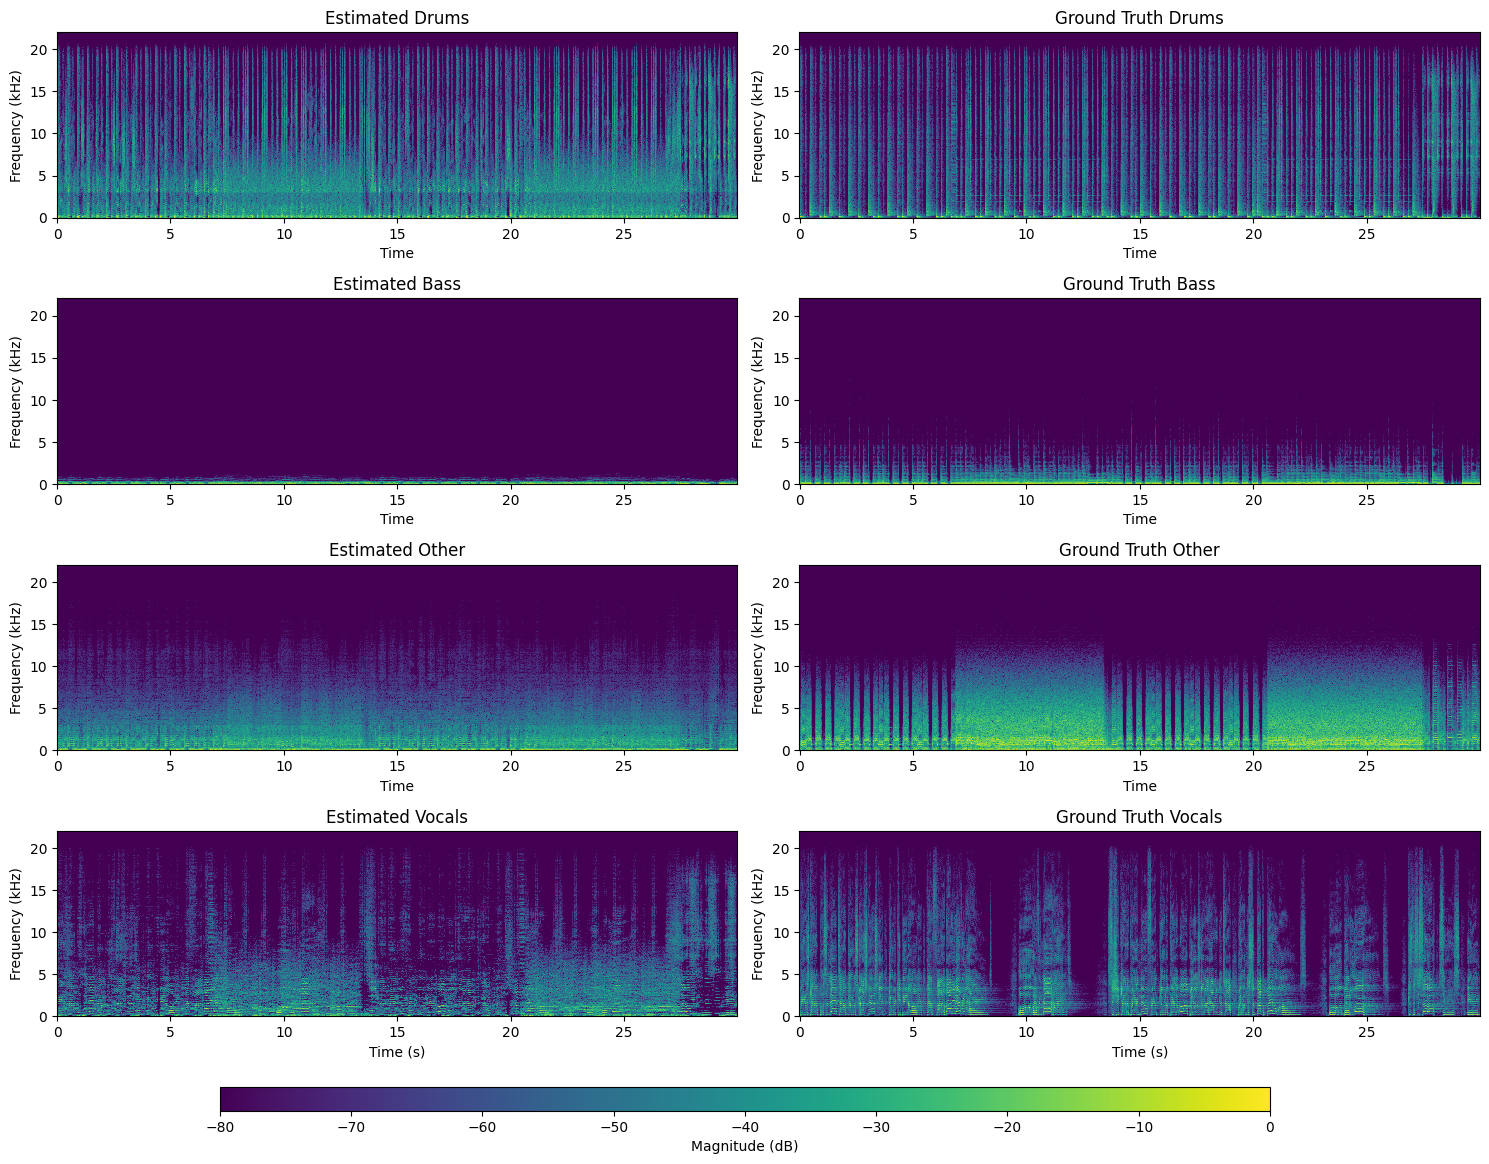

In [16]:
plot_spectrogram_comparison(list(dataset_dict.keys())[0], dataset_dict, separate_sources_HPSS_REPET, duration=SEGMENT_LENGTH) 

In [17]:
sdr_hpps_repet, sar_hpps_repet, sir_hpps_repet = evaluate_metrics_across_dataset(
    separate_sources_HPSS_REPET, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [18:28<00:00, 22.16s/it]


In [18]:
def plot_metrics_results(sdr_collection, sar_collection, sir_collection):
    """
    Create box plots for the SDR, SAR, and SIR results for each stem using raw data.

    Args:
        sdr_collection (torch.Tensor): Tensor containing all SDR results [n_samples, n_stems].
        sar_collection (torch.Tensor): Tensor containing all SAR results [n_samples, n_stems].
        sir_collection (torch.Tensor): Tensor containing all SIR results [n_samples, n_stems].
        model: Model object containing the sources list.
    """
    source_names = ["bass", "drums", "vocals", "other"]

    plt.figure(figsize=(15, 6))

    plt.rcParams.update({'font.size': 16})  # Sets default font size for all elements
    
    plt.subplot(1, 3, 1)
    plt.title("SDR Results")
    plt.boxplot([sdr_collection[:, i].numpy() for i in range(len(source_names))], labels=source_names, patch_artist=True, showfliers=False, notch=True)
    plt.xlabel('Stem')
    plt.ylabel('SDR (dB)')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.title("SAR Results")
    plt.boxplot([sar_collection[:, i].numpy() for i in range(len(source_names))], labels=source_names, patch_artist=True, showfliers=False, notch=True)
    plt.xlabel('Stem')
    plt.ylabel('SAR (dB)')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.title("SIR Results")
    plt.boxplot([sir_collection[:, i].numpy() for i in range(len(source_names))], labels=source_names, patch_artist=True, showfliers=False, notch=True)
    plt.xlabel('Stem')
    plt.ylabel('SIR (dB)')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


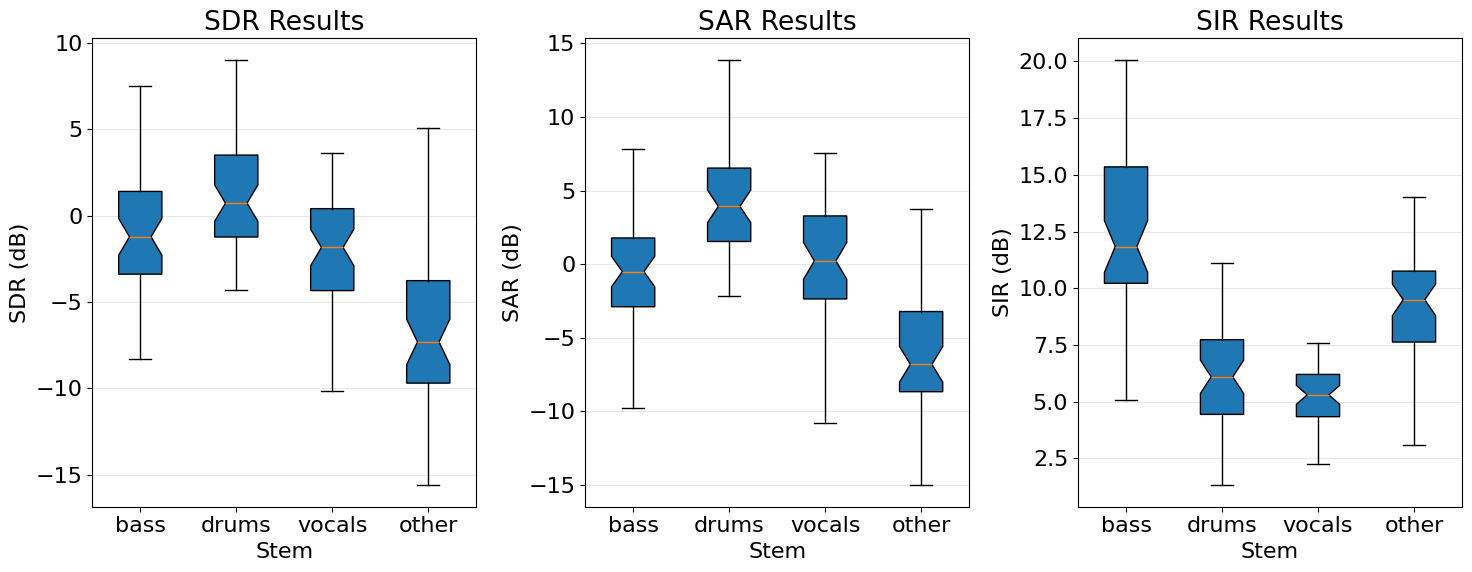

In [19]:
plot_metrics_results(sdr_hpps_repet, sar_hpps_repet, sir_hpps_repet)


### Function Overview: `separate_sources_NNMF`

#### 1. **Audio Loading & STFT**
- Loads audio file and converts to mono
- Computes Short-Time Fourier Transform (STFT) to get magnitude and phase
- Extracts frequency bins for masking

#### 2. **Frequency-Informed Separation**
- Creates frequency masks for each source type:
  - **Drums**: 20-8000 Hz (wide range for transients)
  - **Vocals**: 80-8000 Hz (human voice range)
  - **Bass**: 20-250 Hz (low frequencies)
  - **Other**: 200-16000 Hz (mid-high frequencies)

#### 3. **Hierarchical NMF Processing**
- **Initial HPSS**: Separates harmonic and percussive components
- **Drums**: Applies NMF to percussive component in drum frequency range
- **Bass**: Applies NMF to harmonic component in low frequencies
- **Vocals**: Applies NMF to remaining harmonic content (after bass removal)
- **Other**: Applies NMF to residual harmonic content

#### 4. **NMF Algorithm** (`nmf_separate` function)
- Extracts frequency band using mask
- Runs NMF with specified number of components
- Reconstructs separated source: **S_reconstructed = W @ H**
- Places result back in full frequency spectrum

#### 5. **Post-Processing**
- **Soft Masking**: Reduces artifacts using probabilistic masks
- **Audio Reconstruction**: Combines magnitude with original phase via inverse STFT
- **Normalization**: Prevents clipping by scaling to safe levels

#### Key Advantages
- **Learned Patterns**: NMF discovers instrument-specific spectral templates
- **Frequency Awareness**: Focuses each model on appropriate frequency ranges
- **Flexibility**: Adjustable number of components per source
- **Artifact Reduction**: Soft masking maintains audio quality

In [20]:
def separate_sources_NNMF(
    y,
    sr=sample_rate,
    n_components_drums=4,      # NMF components for drums
    n_components_vocals=6,     # NMF components for vocals  
    n_components_bass=3,       # NMF components for bass
    n_components_other=5,      # NMF components for other
    n_fft=2048,
    hop_length=512,
    # Frequency ranges for each instrument (Hz)
    drums_freq_range=(20, 8000),    # Drums: wide range with emphasis on transients
    vocals_freq_range=(80, 8000),   # Vocals: human voice range
    bass_freq_range=(20, 250),      # Bass: low frequencies
    other_freq_range=(200, 16000),  # Other: mid-high frequencies
    max_iter=200,
    random_state=42
):
    """
    Separate sources from a mixture audio file using NMF-based source separation.
    Args:
        y (np.ndarray): Mixture audio signal.
        sr (int, optional): Sample rate for loading the audio. If None, uses the file's sample rate.
        n_components_drums (int): Number of NMF components for drums.
        n_components_vocals (int): Number of NMF components for vocals.
        n_components_bass (int): Number of NMF components for bass.
        n_components_other (int): Number of NMF components for other sources.
        n_fft (int): Number of FFT components for STFT.
        hop_length (int): Number of samples between successive frames for STFT.
        drums_freq_range (tuple): Frequency range for drums.
        vocals_freq_range (tuple): Frequency range for vocals.
        bass_freq_range (tuple): Frequency range for bass.
        other_freq_range (tuple): Frequency range for other sources.
        max_iter (int): Maximum number of iterations for NMF.
        random_state (int): Random seed for reproducibility.
    Returns:
        dict: A dictionary containing separated audio sources: 'drums', 'bass', 'vocals', 'other'.
    """
    # Ensure the input is a numpy array
    if y.ndim > 1:
        y = librosa.to_mono(y)

    # 2) Compute STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_full = np.abs(D)  # Magnitude spectrogram
    phase = np.angle(D)  # Phase information
    
    # Get frequency bins
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    # 3) Create frequency masks for each source type
    def create_freq_mask(freq_range):
        """Create a frequency mask for the given range"""
        mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        return mask
    
    drums_mask = create_freq_mask(drums_freq_range)
    vocals_mask = create_freq_mask(vocals_freq_range)
    bass_mask = create_freq_mask(bass_freq_range)
    other_mask = create_freq_mask(other_freq_range)
    
    # 4) Apply frequency masking and run NMF on each frequency band
    def nmf_separate(S_masked, n_components, mask):
        """Run NMF on a frequency-masked spectrogram"""
        if not np.any(mask):
            return np.zeros_like(S_masked)
            
        # Extract the relevant frequency band
        S_band = S_masked[mask, :]
        
        if S_band.size == 0 or np.all(S_band == 0):
            return np.zeros_like(S_masked)
        
        # Suppress warnings for convergence
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # Run NMF
            model = NMF(
                n_components=n_components, 
                init='random', 
                random_state=random_state,
                max_iter=max_iter,
                alpha_W=0.1,  # Sparsity for basis vectors
                alpha_H=0.1   # Sparsity for activations
            )
            
            try:
                W = model.fit_transform(S_band)  # Basis spectra
                H = model.components_            # Activations
                
                # Reconstruct the separated component
                S_reconstructed = W @ H
                
                # Create full spectrogram with zeros outside the frequency band
                S_separated = np.zeros_like(S_masked)
                S_separated[mask, :] = S_reconstructed
                
                return S_separated
                
            except Exception as e:
                print(f"NMF failed: {e}")
                return np.zeros_like(S_masked)
    
    # 5) Separate each source using NMF
    
    # Initial HPSS to help guide separation
    S_harmonic, S_percussive = librosa.decompose.hpss(S_full, margin=1.0)
    
    # Drums: focus on percussive component
    S_drums = nmf_separate(S_percussive, n_components_drums, drums_mask)
    
    # Bass: focus on low frequencies in harmonic component  
    S_bass = nmf_separate(S_harmonic, n_components_bass, bass_mask)
    
    # Vocals: focus on mid frequencies in harmonic component after removing bass
    S_harmonic_no_bass = np.maximum(S_harmonic - S_bass, 0.1 * S_harmonic)
    S_vocals = nmf_separate(S_harmonic_no_bass, n_components_vocals, vocals_mask)
    
    # Other: remaining harmonic content
    S_remaining = np.maximum(S_harmonic - S_bass - S_vocals, 0.1 * S_harmonic)
    S_other = nmf_separate(S_remaining, n_components_other, other_mask)
    
    # 6) Post-processing: ensure non-negativity and apply soft masks
    def apply_soft_mask(S_target, S_mixture, power=2, eps=1e-10):
        """Apply soft masking to reduce artifacts"""
        mask = (S_target ** power) / (S_mixture ** power + eps)
        mask = np.clip(mask, 0, 1)
        return mask * S_mixture
    
    # Apply soft masking to reduce artifacts
    S_drums = apply_soft_mask(S_drums, S_full)
    S_vocals = apply_soft_mask(S_vocals, S_full) 
    S_bass = apply_soft_mask(S_bass, S_full)
    S_other = apply_soft_mask(S_other, S_full)
    
    # 7) Reconstruct time-domain signals
    def reconstruct_audio(S_mag, phase_orig):
        """Reconstruct audio from magnitude and phase"""
        S_complex = S_mag * np.exp(1j * phase_orig)
        return librosa.istft(S_complex, hop_length=hop_length, length=len(y))
    
    y_drums = reconstruct_audio(S_drums, phase)
    y_vocals = reconstruct_audio(S_vocals, phase)
    y_bass = reconstruct_audio(S_bass, phase)
    y_other = reconstruct_audio(S_other, phase)
    
    # 8) Normalize to prevent clipping
    def safe_normalize(signal, max_val=0.95):
        """Normalize signal to prevent clipping"""
        if np.max(np.abs(signal)) > 0:
            return max_val * signal / np.max(np.abs(signal))
        return signal
    
    y_drums = safe_normalize(y_drums)
    y_vocals = safe_normalize(y_vocals)  
    y_bass = safe_normalize(y_bass)
    y_other = safe_normalize(y_other)
    
    return {
        'drums': y_drums,
        'bass': y_bass,
        'vocals': y_vocals,
        'other': y_other,
    }

In [ ]:
display_separation_results(list(dataset_dict.keys())[0], dataset_dict, separate_sources_NNMF, duration=SEGMENT_LENGTH)  # Adjust duration as needed

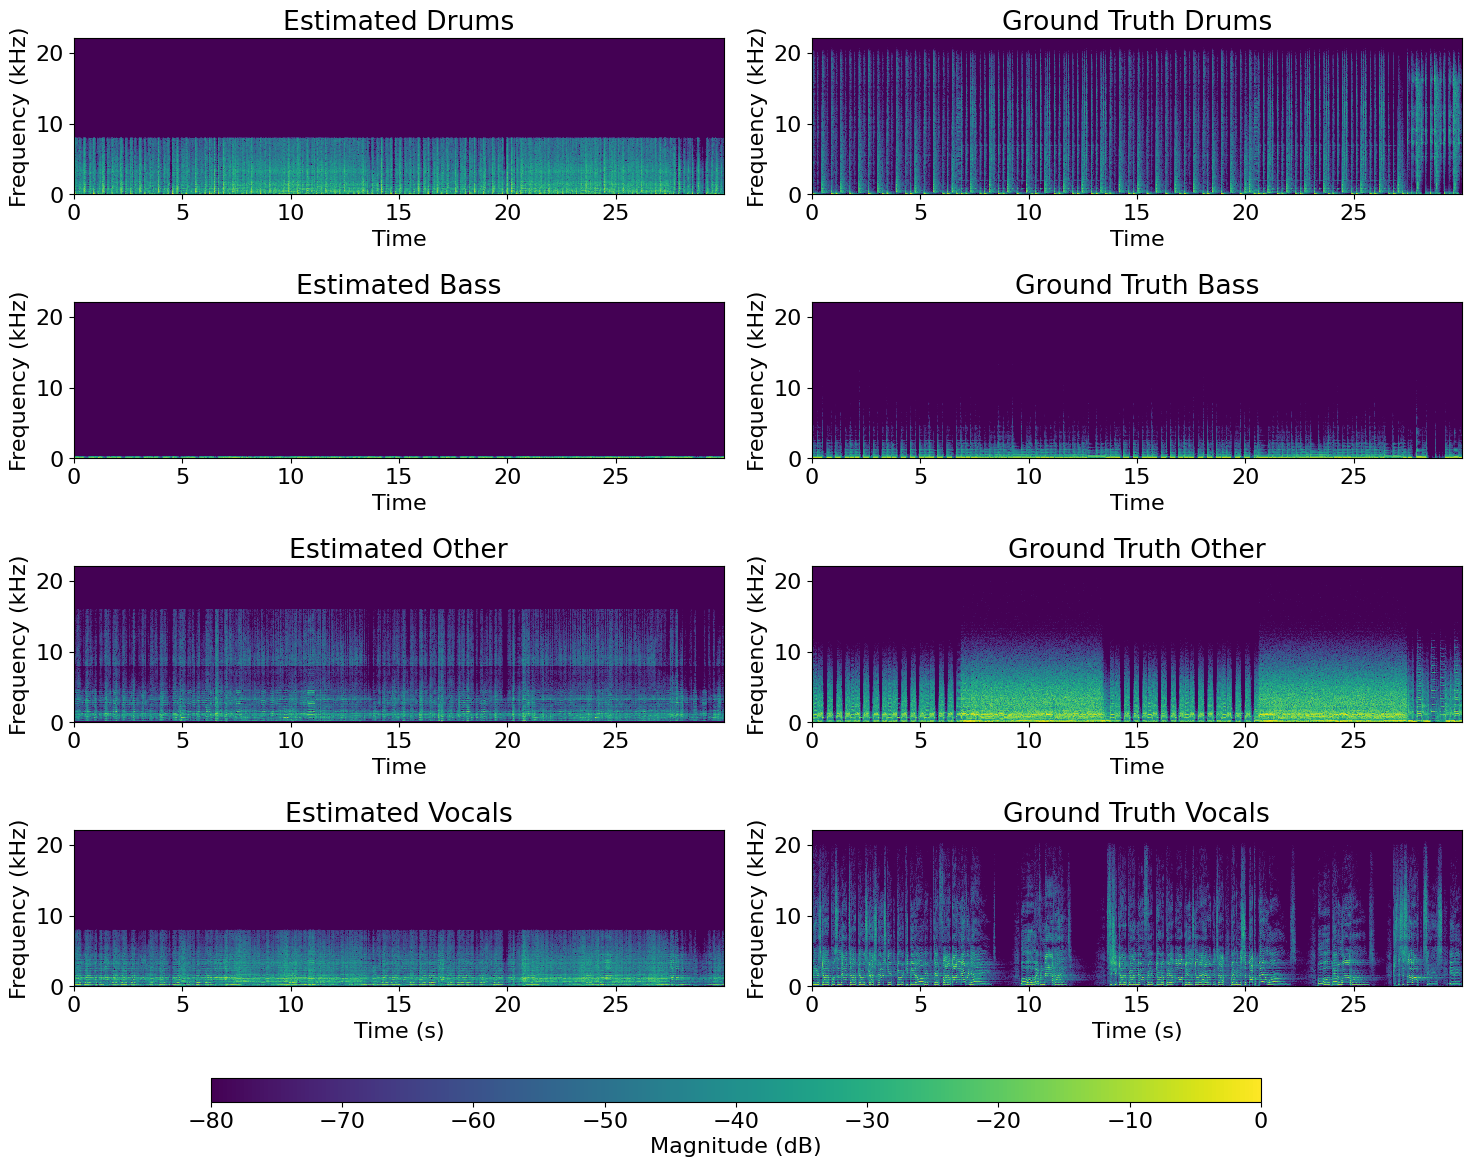

In [21]:
plot_spectrogram_comparison(list(dataset_dict.keys())[0], dataset_dict, separate_sources_NNMF, duration=SEGMENT_LENGTH) 

In [22]:
sdr_nnmf, sar_nnmf, sir_nnmf = evaluate_metrics_across_dataset(
    separate_sources_NNMF, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [16:01<00:00, 19.23s/it]


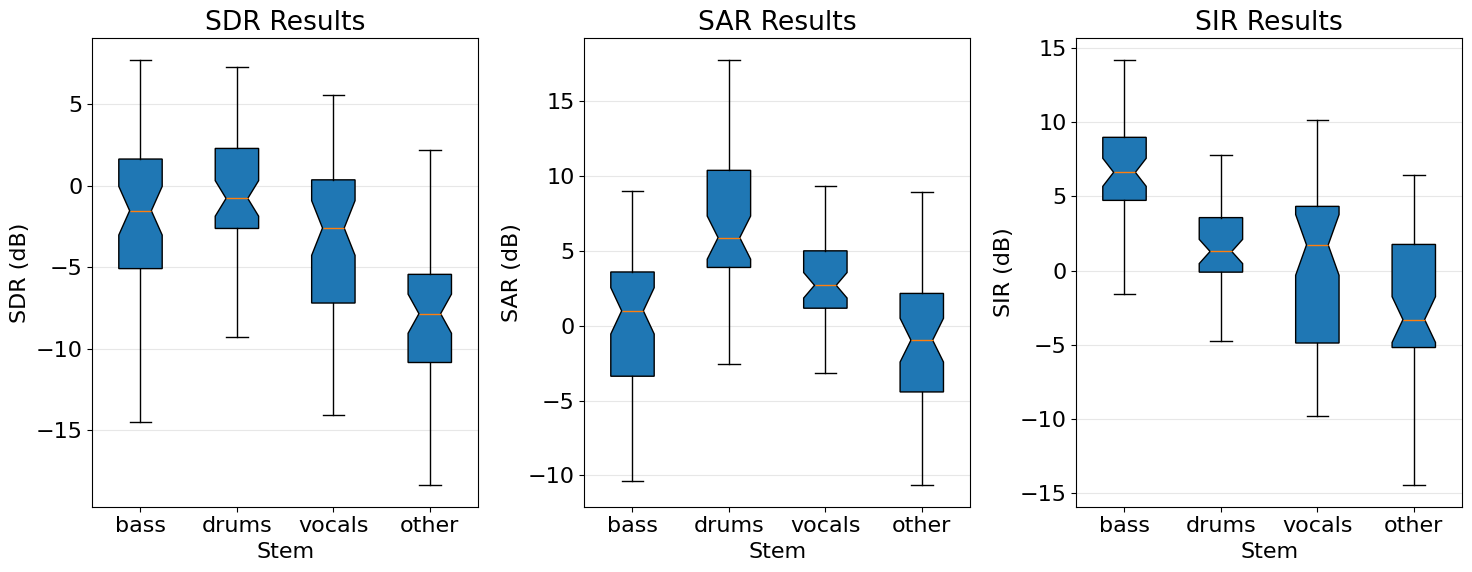

In [23]:
plot_metrics_results(sdr_nnmf, sar_nnmf, sir_nnmf)

## U-Net

In [24]:
from torch.utils.data import DataLoader, Dataset
import glob
import torch.nn as nn

In [25]:
def wav_to_mag(wav, n_fft=1024, hop_length=512):
    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    return torch.tensor(magnitude.T, dtype=torch.float32)  # (time, freq)

**Dataset Loader Class**

In [26]:
class MUSDB18Dataset(Dataset):
    def __init__(self, root_dir, split='train', sr=16000, n_fft=1024, hop_length=512, target='vocals', segment_length=60.0):
        self.root_dir = root_dir
        self.split = split
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target = target
        self.segment_length = segment_length  # Duration in seconds
        self.segment_samples = int(segment_length * sr)  # Convert to samples
        
        # Get all song folders
        self.song_dirs = [d for d in glob.glob(os.path.join(root_dir, split, '*')) if os.path.isdir(d)]
        
        # Filter out songs that don't have all required stems
        valid_songs = []
        for song_dir in self.song_dirs:
            stems = ['mixture.wav', 'drums.wav', 'bass.wav', 'vocals.wav', 'other.wav']
            if all(os.path.exists(os.path.join(song_dir, stem)) for stem in stems):
                valid_songs.append(song_dir)
        
        self.song_dirs = valid_songs
        print(f"Found {len(self.song_dirs)} valid songs in {split} set")

    def __len__(self):
        return len(self.song_dirs)

    def __getitem__(self, idx):
        song_dir = self.song_dirs[idx]
        
        # Load mixture and target stem
        mixture_path = os.path.join(song_dir, 'mixture.wav')
        target_path = os.path.join(song_dir, f'{self.target}.wav')
        
        # Load audio files with fixed duration
        mixture, _ = librosa.load(mixture_path, sr=self.sr, mono=True, duration=self.segment_length)
        target, _ = librosa.load(target_path, sr=self.sr, mono=True, duration=self.segment_length)
        
        # Ensure exact length (pad if necessary)
        if len(mixture) < self.segment_samples:
            mixture = np.pad(mixture, (0, self.segment_samples - len(mixture)), mode='constant', constant_values=0)
        if len(target) < self.segment_samples:
            target = np.pad(target, (0, self.segment_samples - len(target)), mode='constant', constant_values=0)
            
        # Truncate if longer (shouldn't happen with duration parameter, but just in case)
        mixture = mixture[:self.segment_samples]
        target = target[:self.segment_samples]
        
        # Convert to magnitude spectrograms
        mixture_mag = wav_to_mag(mixture, n_fft=self.n_fft, hop_length=self.hop_length)
        target_mag = wav_to_mag(target, n_fft=self.n_fft, hop_length=self.hop_length)
        
        return mixture_mag, target_mag


### U-Net Architecture

#### Overview
This U-Net implementation combines convolutional neural networks with LSTM layers to perform audio source separation on spectrograms. The architecture follows an encoder-decoder design with skip connections and temporal modeling.

#### Architecture Components

##### **Encoder (Downsampling Path)**
- **3 encoding blocks** with progressively increasing channel dimensions
- Each block contains: `Conv1D → BatchNorm → ReLU → Conv1D → BatchNorm → ReLU`
- **MaxPool1D** for downsampling between blocks
- Channel progression: `n_bins → 256 → 512 → 1024`

##### **Bottleneck with Temporal Modeling**
- **Convolutional bottleneck**: Expands to 2048 channels
- **Bidirectional LSTM**: 2 layers for temporal sequence modeling
- Captures long-term dependencies in audio sequences

##### **Decoder (Upsampling Path)**
- **3 decoding blocks** with symmetric upsampling
- **ConvTranspose1D** for upsampling + **Skip connections** from encoder
- Progressively reduces channels back to original spectrogram dimensions
- **Interpolation** handles size mismatches between encoder/decoder features

##### **Output & Masking**
- Final convolution outputs a **multiplicative mask**
- **Element-wise multiplication** with input spectrogram
- Preserves original audio structure while isolating target source

#### Key Features

| Component | Purpose | Benefit |
|-----------|---------|---------|
| **Skip Connections** | Preserve fine-grained details | Better reconstruction quality |
| **LSTM Layers** | Model temporal dependencies | Capture musical patterns |
| **Multiplicative Masking** | Source-aware filtering | Maintains audio coherence |
| **BatchNorm + ReLU** | Stable training | Faster convergence |

#### Input/Output
- **Input**: Spectrogram `(batch, time, frequency)`
- **Output**: Separated source spectrogram `(batch, time, frequency)`
- **Process**: Learns to generate optimal masks for target instrument isolation

This hybrid CNN-LSTM architecture effectively combines spatial feature extraction with temporal sequence modeling, making it well-suited for the complex task of music source separation.

In [27]:
class UNet(nn.Module):
    def __init__(self, n_bins=513, hidden_size=256):
        super(UNet, self).__init__()
        self.n_bins = n_bins
        
        # Encoder (downsampling path)
        self.enc1 = nn.Sequential(
            nn.Conv1d(n_bins, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 2, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU()
        )
        
        self.enc3 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(hidden_size * 2, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 4, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )
        
        # Bottleneck with LSTM
        self.bottleneck_conv = nn.Conv1d(hidden_size * 4, hidden_size * 8, kernel_size=3, padding=1)
        self.bottleneck_bn = nn.BatchNorm1d(hidden_size * 8)
        self.bottleneck_relu = nn.ReLU()
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=hidden_size * 8,
            hidden_size=hidden_size * 4,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        
        # Decoder (upsampling path)
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size * 8, hidden_size * 4, kernel_size=2, stride=2),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )
        self.dec3_conv = nn.Sequential(
            nn.Conv1d(hidden_size * 8, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 4, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )
        
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size * 4, hidden_size * 2, kernel_size=2, stride=2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU()
        )
        self.dec2_conv = nn.Sequential(
            nn.Conv1d(hidden_size * 4, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 2, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size * 2, hidden_size, kernel_size=2, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        self.dec1_conv = nn.Sequential(
            nn.Conv1d(hidden_size * 2, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
        # Output layer
        self.output = nn.Sequential(
            nn.Conv1d(hidden_size, n_bins, kernel_size=1),
            nn.ReLU()  # Ensure non-negative output for masking
        )
        
    def forward(self, x):
        # x shape: (batch, time, freq) -> need (batch, freq, time) for conv1d
        x_input = x.clone()
        x = x.transpose(1, 2)  # (batch, freq, time)
        
        # Encoder
        enc1_out = self.enc1(x)  # (batch, hidden_size, time)
        enc2_out = self.enc2(enc1_out)  # (batch, hidden_size*2, time/2)
        enc3_out = self.enc3(enc2_out)  # (batch, hidden_size*4, time/4)
        
        # Bottleneck
        bottleneck = self.bottleneck_relu(self.bottleneck_bn(self.bottleneck_conv(enc3_out)))
        
        # LSTM processing
        # Reshape for LSTM: (batch, time, features)
        lstm_input = bottleneck.transpose(1, 2)  # (batch, time/4, hidden_size*8)
        lstm_out, _ = self.lstm(lstm_input)  # (batch, time/4, hidden_size*8)
        lstm_out = lstm_out.transpose(1, 2)  # (batch, hidden_size*8, time/4)
        
        # Decoder with skip connections
        dec3_up = self.dec3(lstm_out)  # Upsample
        # Handle size mismatch with interpolation if needed
        if dec3_up.size(2) != enc3_out.size(2):
            dec3_up = torch.nn.functional.interpolate(dec3_up, size=enc3_out.size(2), mode='linear', align_corners=False)
        dec3_concat = torch.cat([dec3_up, enc3_out], dim=1)  # Skip connection
        dec3_out = self.dec3_conv(dec3_concat)
        
        dec2_up = self.dec2(dec3_out)
        if dec2_up.size(2) != enc2_out.size(2):
            dec2_up = torch.nn.functional.interpolate(dec2_up, size=enc2_out.size(2), mode='linear', align_corners=False)
        dec2_concat = torch.cat([dec2_up, enc2_out], dim=1)
        dec2_out = self.dec2_conv(dec2_concat)
        
        dec1_up = self.dec1(dec2_out)
        if dec1_up.size(2) != enc1_out.size(2):
            dec1_up = torch.nn.functional.interpolate(dec1_up, size=enc1_out.size(2), mode='linear', align_corners=False)
        dec1_concat = torch.cat([dec1_up, enc1_out], dim=1)
        dec1_out = self.dec1_conv(dec1_concat)
        
        # Output
        mask = self.output(dec1_out)  # (batch, freq, time)
        mask = mask.transpose(1, 2)  # (batch, time, freq)
        
        # Apply mask to input
        return mask * x_input

## Training and Validation Pipeline

### Overview
This function implements a comprehensive training pipeline for music source separation models with robust early stopping and model checkpointing mechanisms.

### Training Configuration

#### Optimization Setup
- **Optimizer**: Adam with learning rate `1e-3`
- **Loss Function**: Mean Squared Error (MSE)
- **Training Epochs**: Maximum 100 epochs
- **Device Management**: Automatic model transfer to specified device (CPU/GPU)

#### Early Stopping Strategy
- **Patience**: 10 epochs without validation improvement
- **Best Model Tracking**: Continuous monitoring of validation loss
- **Model Checkpointing**: Saves best performing model automatically

### Training Loop Structure

#### Forward Pass & Backpropagation
```python
for mixture_mag, target_mag in train_loader:
    optimizer.zero_grad()
    output = model(mixture_mag)
    loss = criterion(output, target_mag)
    loss.backward()
    optimizer.step()
```

#### Progress Monitoring
- **Batch-level logging**: Progress printed every 10 batches
- **Epoch-level metrics**: Average training and validation losses
- **Real-time feedback**: Loss values displayed during training

### Validation Process

#### Evaluation Mode
- **No gradient computation**: `torch.no_grad()` for memory efficiency
- **Model evaluation mode**: `model.eval()` disables dropout/batch norm updates
- **Comprehensive validation**: Processes entire validation dataset

#### Performance Tracking
- **Loss aggregation**: Accumulates validation loss across all batches
- **Average computation**: Calculates mean validation loss per epoch
- **Comparison logic**: Determines if current model outperforms previous best

### Model Persistence

#### Checkpoint Strategy
- **Target-specific saving**: Models saved with target instrument identifier
- **State dictionary**: Saves only model parameters for efficiency
- **Best model retention**: Overwrites checkpoint only when validation improves

#### Early Termination
- **Patience mechanism**: Stops training after 10 epochs without improvement
- **Resource optimization**: Prevents overfitting and saves computational time
- **Final metrics**: Reports best achieved validation loss

### Key Features

| Component | Purpose | Benefit |
|-----------|---------|---------|
| **Early Stopping** | Prevent overfitting | Optimal model selection |
| **Model Checkpointing** | Save best weights | Reproducible results |
| **Progress Logging** | Monitor training | Real-time diagnostics |
| **Device Management** | GPU/CPU flexibility | Hardware optimization |

### Input Parameters
- **model**: Neural network architecture to train
- **device**: Computing device (CPU/CUDA/MPS)
- **train_loader**: Training data iterator
- **test_loader**: Validation data iterator
- **target**: Target instrument name for model identification

This training pipeline ensures robust model development with automatic optimization stopping and best model preservation.

In [28]:
def train_and_validate_model(model, device, train_loader, test_loader, target):
    """ Train and validate the OpenUnmix model with early stopping and model saving. """
    # Move model to appropriate device
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training loop with early stopping and model saving
    epochs = 100
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        num_batches = 0
    
        for mixture_mag, target_mag in train_loader:
            mixture_mag = mixture_mag.to(device)
            target_mag = target_mag.to(device)
        
            optimizer.zero_grad()
            output = model(mixture_mag)
            loss = criterion(output, target_mag)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item()
            num_batches += 1
        
        # Print progress every 10 batches
            if num_batches % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {num_batches}, Loss: {loss.item():.4f}")
    
        avg_train_loss = train_loss / num_batches
    
    # Validation
        model.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for mixture_mag, target_mag in test_loader:
                mixture_mag = mixture_mag.to(device)
                target_mag = target_mag.to(device)
                output = model(mixture_mag)
                loss = criterion(output, target_mag)
                val_loss += loss.item()
                val_batches += 1
    
        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping and model saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        # Save the best model
            torch.save(model.state_dict(), f'best_model_{target}.pth')
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break

    print("Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")

In [38]:
def train_model(target):
    """ Train the model and evaluate on the test set. """
    print(f"=== TRAINING MODEL FOR {target.upper()} ===")
    
    # Create datasets
    train_dataset = MUSDB18Dataset('./musdb18hq', split='train', target=target)
    test_dataset = MUSDB18Dataset('./musdb18hq', split='test', target=target)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('mps' if torch.backends.mps.is_available() else device)  # For Apple Silicon

    model_UNet = UNet(n_bins=513)  # 513 bins for n_fft=1024

    if os.path.exists(f'best_model_{target}.pth'):
        print(f"Loading existing model for {target}...")
        model_UNet.load_state_dict(torch.load(f'best_model_{target}.pth', map_location=device))
        model_UNet.to(device)
    else:
        print(f"No existing model found for {target}, starting training from scratch.")
        # Train and validate the model
        train_and_validate_model(model_UNet, device, train_loader, test_loader, target=target)

        model_UNet.load_state_dict(torch.load(f'best_model_{target}.pth', map_location=device))
        model_UNet.to(device)

    return model_UNet, device


In [39]:
model_vocals, device = train_model('vocals')
model_drums, device = train_model('drums')
model_bass, device = train_model('bass')
model_other, device = train_model('other')

=== TRAINING MODEL FOR VOCALS ===
Found 100 valid songs in train set
Found 50 valid songs in test set
Loading existing model for vocals...
=== TRAINING MODEL FOR DRUMS ===
Found 100 valid songs in train set
Found 50 valid songs in test set
Loading existing model for drums...


=== TRAINING MODEL FOR BASS ===
Found 100 valid songs in train set
Found 50 valid songs in test set
Loading existing model for bass...
=== TRAINING MODEL FOR OTHER ===
Found 100 valid songs in train set
Found 50 valid songs in test set
Loading existing model for other...


In [48]:
def UNet_separate_music_sources(mixture_audio, model_vocals=model_vocals, model_drums=model_drums, model_bass=model_bass, model_other=model_other, device=device):
    """
    Separate music sources using trained UNet models for vocals, drums, bass, and other instruments.
    Args:
        mixture_audio (np.ndarray): Mixture audio signal.
        model_vocals (UNet): Trained UNet model for vocals.
        model_drums (UNet): Trained UNet model for drums.
        model_bass (UNet): Trained UNet model for bass.
        model_other (UNet): Trained UNet model for other instruments.
        device (torch.device): Device to run the models on (CPU or GPU).
    Returns:    
        dict: A dictionary containing separated audio sources: 'vocals', 'drums', 'bass', 'other'.
    """
    with torch.no_grad():

        # convert mixture_audio to mono if stereo
        if mixture_audio.ndim > 1:
            mixture_audio = librosa.to_mono(mixture_audio)

        mixture_mag = np.transpose(np.abs(librosa.stft(mixture_audio, n_fft=1024, hop_length=512)))
        mixture_mag = torch.tensor(mixture_mag).unsqueeze(0).to(device)

        predicted_mag_vocals = model_vocals(mixture_mag)
        predicted_mag_drums = model_drums(mixture_mag)
        predicted_mag_bass = model_bass(mixture_mag)
        predicted_mag_other = model_other(mixture_mag)
        # Get original phase from mixture
        mixture_stft = librosa.stft(mixture_audio, n_fft=1024, hop_length=512)
        mixture_phase = np.angle(mixture_stft)
        
        # Reconstruct audio using istft with original phase
        predicted_audio_vocals = librosa.istft(predicted_mag_vocals[0].cpu().numpy().T * np.exp(1j * mixture_phase), hop_length=512, length=len(mixture_audio))
        predicted_audio_drums = librosa.istft(predicted_mag_drums[0].cpu().numpy().T * np.exp(1j * mixture_phase), hop_length=512, length=len(mixture_audio))
        predicted_audio_bass = librosa.istft(predicted_mag_bass[0].cpu().numpy().T * np.exp(1j * mixture_phase), hop_length=512, length=len(mixture_audio))
        predicted_audio_other = librosa.istft(predicted_mag_other[0].cpu().numpy().T * np.exp(1j * mixture_phase), hop_length=512, length=len(mixture_audio))

    return {
        'vocals': predicted_audio_vocals,
        'drums': predicted_audio_drums,
        'bass': predicted_audio_bass,
        'other': predicted_audio_other
    }

In [ ]:
def process_audio_stems(dataset_dict):
    """
    Process audio stems in the dataset dictionary by converting to mono, computing STFT, and converting back to time domain.
    Args:
        dataset_dict (dict): Dictionary containing the dataset with track names as keys and stem waveforms as values.
    Returns:
        dict: Processed dataset dictionary with the same structure but with processed audio stems.
    """

    dataset_dict_processed = {}

    for track_name, stems_dict in tqdm(dataset_dict.items()):
        processed_stems = {}
        for stem_name, stem_waveform in stems_dict.items():
        # Convert to mono if stereo
            if stem_waveform.ndim > 1:
                stem_waveform = librosa.to_mono(stem_waveform.numpy())
        
        # Compute STFT
            stft = librosa.stft(stem_waveform, n_fft=1024, hop_length=512)
            magnitude = np.abs(stft)
        
        # Convert back to time domain using Griffin-Lim
            processed_waveform = librosa.istft(magnitude * np.exp(1j * np.angle(stft)), hop_length=512, length=len(stem_waveform))
        
            processed_stems[stem_name] = torch.tensor(processed_waveform)
    
        dataset_dict_processed[track_name] = processed_stems
    
    return dataset_dict_processed

dataset_dict_processed = process_audio_stems(dataset_dict)


  0%|          | 0/50 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
display_separation_results(list(dataset_dict.keys())[0], dataset_dict, UNet_separate_music_sources, duration=SEGMENT_LENGTH)  # Adjust duration as needed

Mixture magnitude shape: torch.Size([1, 2584, 513]), dtype: torch.float32, device: mps:0


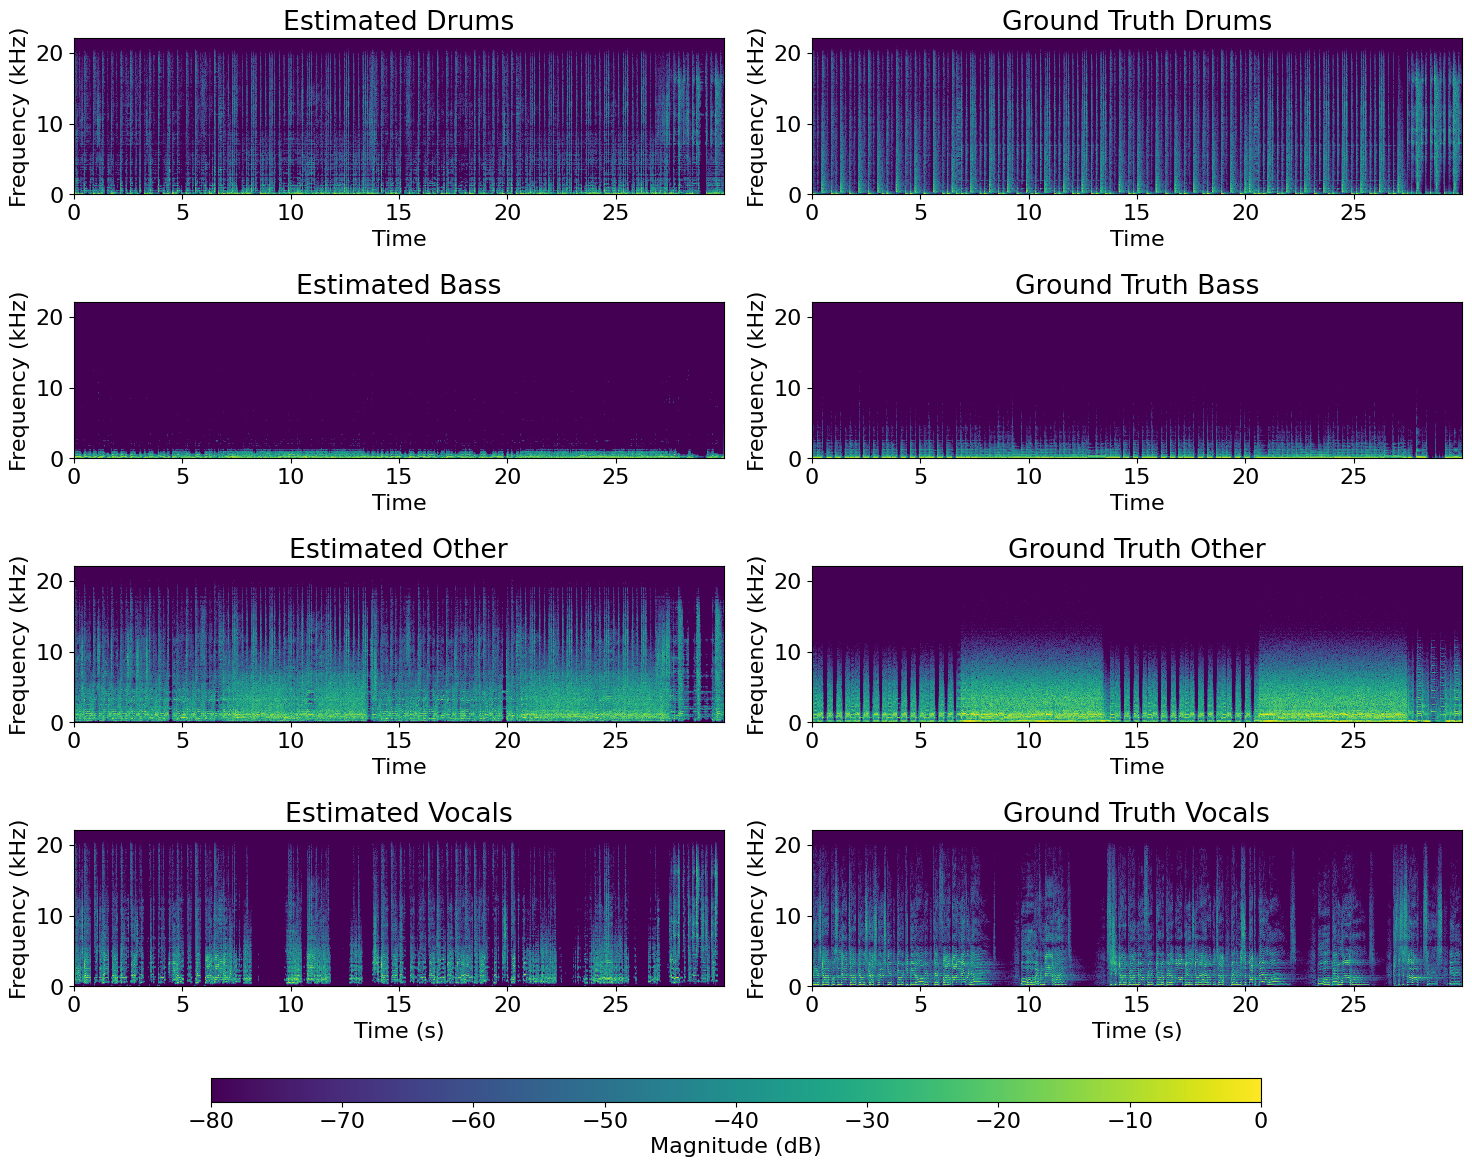

In [43]:
plot_spectrogram_comparison(list(dataset_dict.keys())[0], dataset_dict, UNet_separate_music_sources, duration=SEGMENT_LENGTH) 

In [49]:
sdr_unet, sar_unet, sir_unet = evaluate_metrics_across_dataset(
    UNet_separate_music_sources, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [15:45<00:00, 18.92s/it]


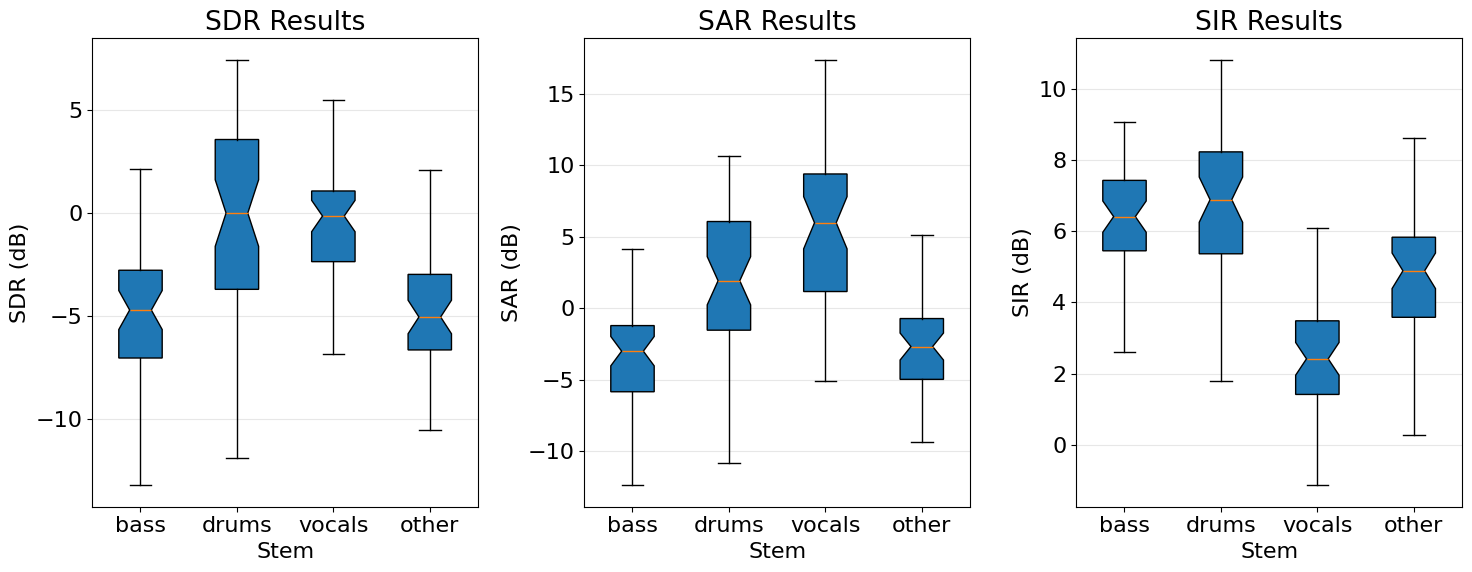

In [50]:
plot_metrics_results(sdr_unet, sar_unet, sir_unet)

## Pre-trained Demucs Model: Leveraging State-of-the-Art Performance

### Motivation for Using Pre-trained Models

#### Computational Advantages
Pre-trained models offer significant computational benefits that make them ideal for high-quality music source separation:

- **Training Complexity**: Demucs requires extensive computational resources, often taking weeks to train on large datasets with multiple GPUs
- **Dataset Scale**: The original Demucs models were trained on massive datasets including MUSDB18, DnR, and additional proprietary music collections
- **Resource Efficiency**: Utilizing pre-trained weights eliminates the need for costly training infrastructure and time investment

#### Performance Benefits

##### Proven Track Record
- **MUSDB18 Benchmark**: Pre-trained Demucs models consistently achieve state-of-the-art results on standard evaluation metrics
- **Competition Performance**: Demucs has won multiple Music Demixing Challenge competitions, demonstrating superior separation quality
- **Industry Adoption**: Widely used in professional audio applications due to reliable performance

##### Architectural Optimization
- **Hybrid Design**: Combines convolutional and transformer architectures optimized through extensive experimentation
- **Multi-scale Processing**: Handles both time-domain and frequency-domain representations simultaneously
- **Advanced Training Techniques**: Incorporates sophisticated data augmentation, loss functions, and regularization strategies

#### Expected Results Justification

Using a pre-trained Demucs model, we expect the best results because:

1. **Extensive Training Data**: Models have seen diverse musical genres, instruments, and recording conditions
2. **Optimized Hyperparameters**: All training parameters have been fine-tuned through rigorous experimentation
3. **Robust Generalization**: Pre-trained weights capture universal audio separation patterns applicable to new music
4. **Quality Assurance**: Models have undergone extensive validation and quality testing before public release


This approach allows us to demonstrate state-of-the-art separation capabilities while dedicating time to understanding model behavior and developing comparative insights with other architectures.

In [51]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model_demucs = bundle.get_model()
sample_rate = bundle.sample_rate

In [52]:
cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model_demucs.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

In [53]:
def separate_sources_demucs(
    mix,
    model=model_demucs,
    sample_rate=sample_rate,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=device,
    normalize=False,
):
    """
    Separate sources from a mixture using the provided demucs model.
    Args:
        mix: The input mixture tensor (batch, channels, length).
        model: The separation model.
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        final: The separated sources tensor (batch, sources[drums, bass, other, vocals], channels, length). #CORRECT ORDER UPDATED
    """

    # convert mix to tensor if not already
    if not isinstance(mix, torch.Tensor):
        mix = torch.tensor(mix, dtype=torch.float32).to(device)

    if mix.ndim == 2:
        mix = mix.unsqueeze(0).to(device)  # add batch dimension if missing

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # normalize the input by its RMS
    if normalize:
        # mix = mix / torch.sqrt(torch.mean(mix ** 2, dim=-1, keepdim=True))
        mix = mix / torch.max(torch.abs(mix))

    # chunk_len for entire 30s, no overlap
    chunk_len = int(mix.shape[2] * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk).to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0


     # instead of final return a dictionary with the sources containing numpy arrays
    separated_sources = {
        'drums': final[:, 0, :, :].squeeze().cpu().numpy(),
        'bass': final[:, 1, :, :].squeeze().cpu().numpy(),
        'other': final[:, 2, :, :].squeeze().cpu().numpy(),
        'vocals': final[:, 3, :, :].squeeze().cpu().numpy()
    }

    return separated_sources

In [ ]:
display_separation_results(list(dataset_dict.keys())[0], dataset_dict, separate_sources_demucs, duration=SEGMENT_LENGTH)  # Adjust duration as needed

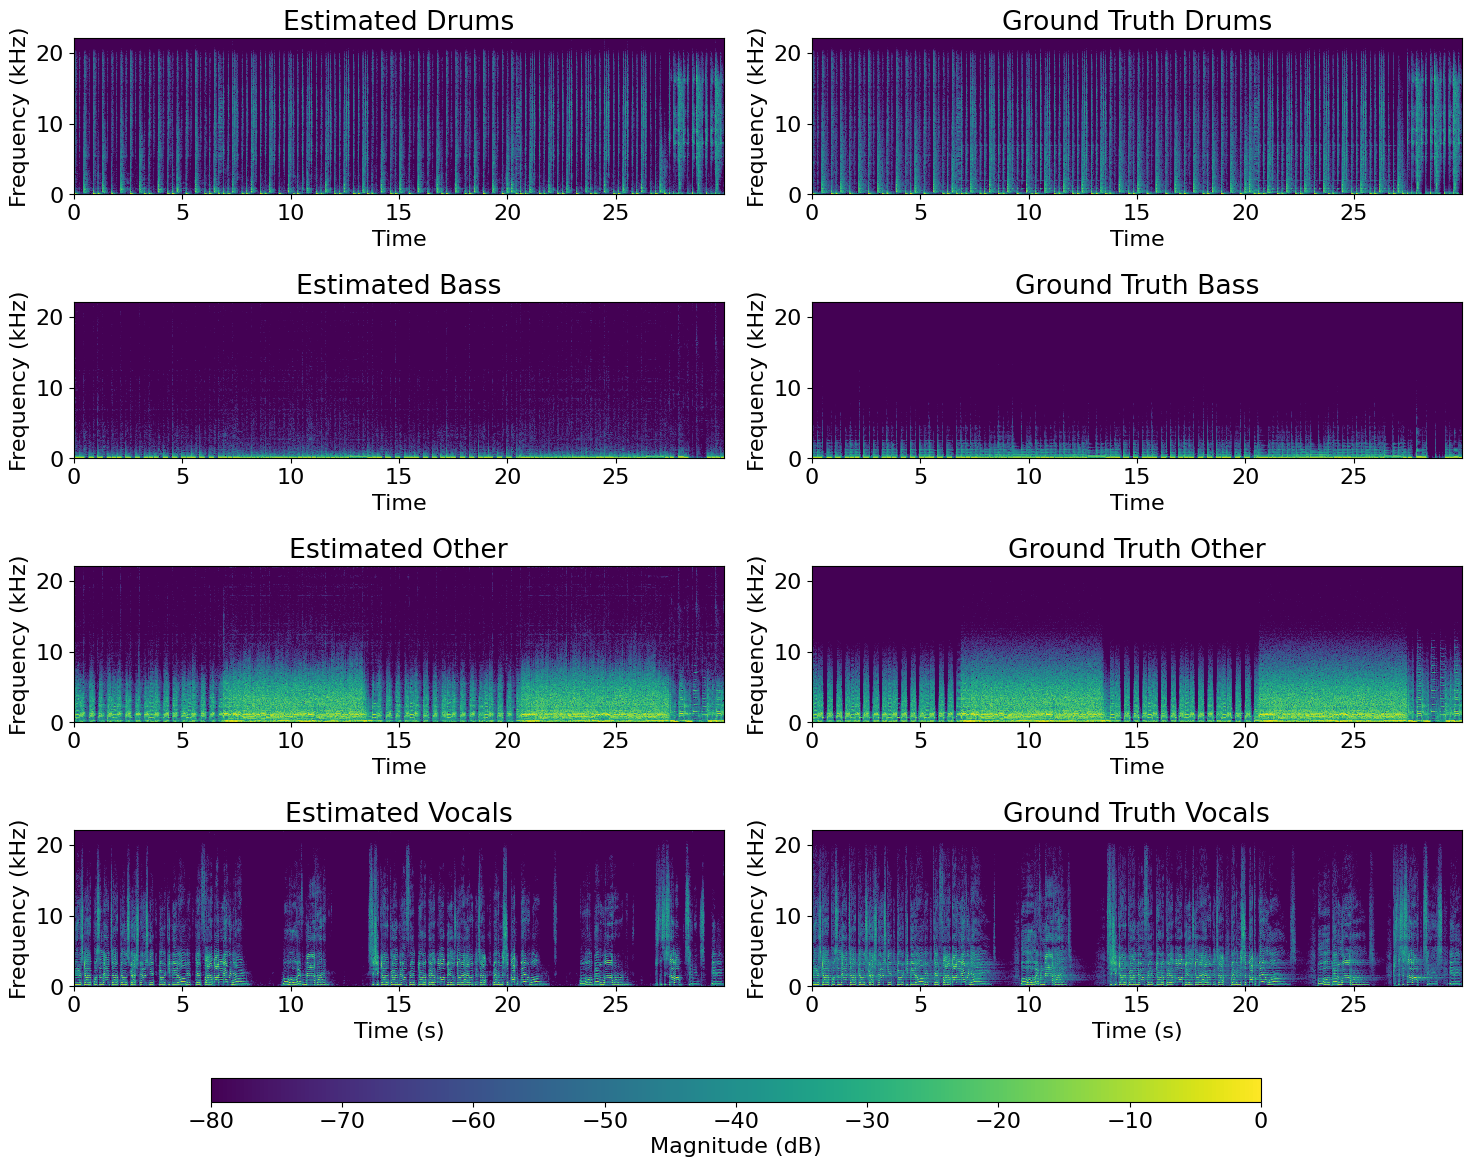

In [55]:
plot_spectrogram_comparison(list(dataset_dict.keys())[0], dataset_dict, separate_sources_demucs, duration=SEGMENT_LENGTH)  # Adjust duration as needed

In [56]:
sdr_demucs, sar_demucs, sir_demucs = evaluate_metrics_across_dataset(
    separate_sources_demucs, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [15:27<00:00, 18.55s/it]


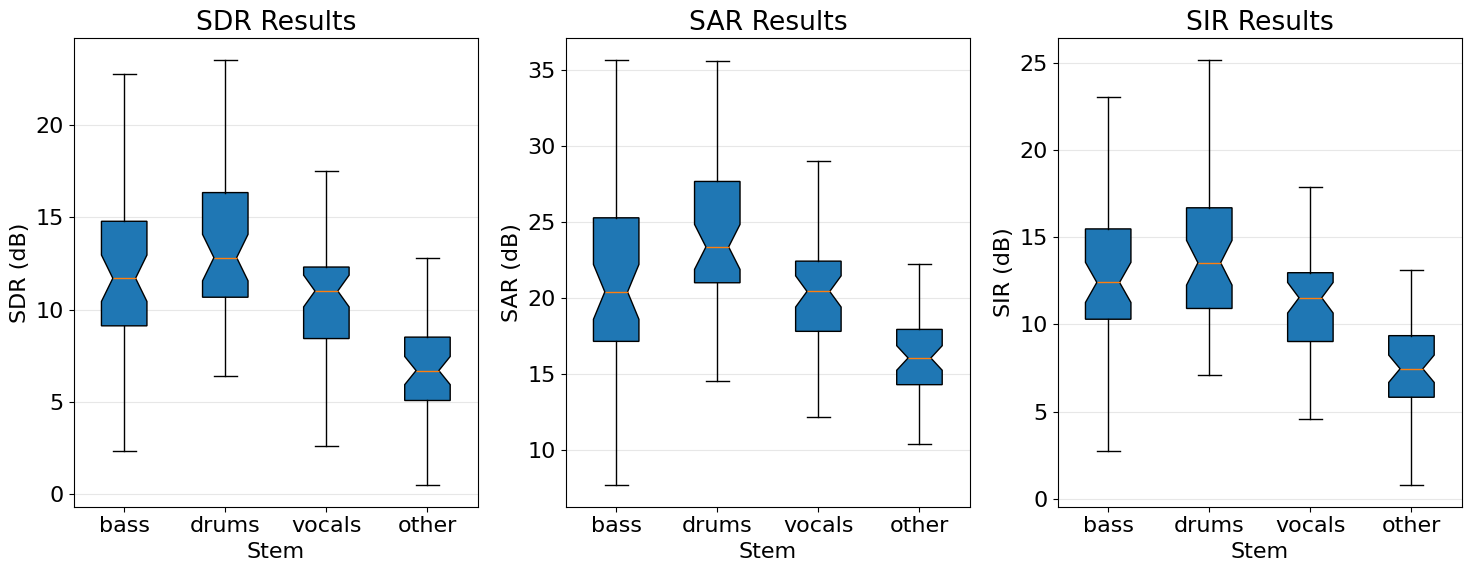

In [57]:
plot_metrics_results(sdr_demucs, sar_demucs, sir_demucs)

## Simplified Demucs

In [58]:
import random
import torch.nn.functional as F

In [59]:
# Get track lists
train_tracks = glob.glob('./musdb18hq/train/*/*.wav')
test_tracks = glob.glob('./musdb18hq/test/*/*.wav')
print(f"Train tracks: {len(train_tracks)}, Test tracks: {len(test_tracks)}")

Train tracks: 500, Test tracks: 250


In [60]:
# ============================================
# ORIGINAL ARCHITECTURE (UNCHANGED)
# ============================================
class GLU(nn.Module):
    """Gated Linear Unit activation"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        out, gate = x.chunk(2, dim=self.dim)
        return out * torch.sigmoid(gate)

In [61]:
class EncoderBlock(nn.Module):
    """Encoder block with proper padding"""
    def __init__(self, in_channels, out_channels, kernel_size=8, stride=4):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = (kernel_size - stride) // 2

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=self.padding)
        self.conv1x1 = nn.Conv1d(out_channels, out_channels * 2, kernel_size=1)
        self.glu = GLU(dim=1)
        self.relu = nn.ReLU()

        # Initialize weights
        nn.init.xavier_uniform_(self.conv.weight)
        nn.init.xavier_uniform_(self.conv1x1.weight)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.conv1x1(x)
        x = self.glu(x)
        return x

In [62]:
class DecoderBlock(nn.Module):
    """Decoder block with proper padding"""
    def __init__(self, in_channels, out_channels, kernel_size=8, stride=4, is_last=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.is_last = is_last
        self.padding = (kernel_size - stride) // 2

        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv1x1 = nn.Conv1d(in_channels, in_channels * 2, kernel_size=1)
        self.glu = GLU(dim=1)
        self.convtr = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride,
            padding=self.padding, output_padding=0
        )

        # Initialize weights
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv1x1.weight)
        nn.init.xavier_uniform_(self.convtr.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv1x1(x)
        x = self.glu(x)
        x = self.convtr(x)
        if not self.is_last:
            x = self.relu(x)
        return x


In [63]:
class SimplifiedDemucs(nn.Module):
    """Demucs with exact size matching - MINIMAL CHANGES"""
    def __init__(self, sources=4, channels=16, layers=3, sample_length=88200):
        super().__init__()
        self.sources = sources
        self.channels = channels
        self.layers = layers
        self.sample_length = sample_length

        # Build encoder
        self.encoders = nn.ModuleList()
        self.encoder_channels = []

        in_ch = 2  # stereo input
        for i in range(layers):
            out_ch = channels * (2 ** min(i, 3))
            encoder = EncoderBlock(in_ch, out_ch)
            self.encoders.append(encoder)
            self.encoder_channels.append(out_ch)
            in_ch = out_ch

        # LSTM with initialization
        lstm_ch = in_ch
        self.lstm = nn.LSTM(lstm_ch, lstm_ch, num_layers=2, batch_first=True, bidirectional=True)
        self.lstm_conv = nn.Conv1d(lstm_ch * 2, lstm_ch, kernel_size=1)  # *2 for bidirectional
        self.lstm_relu = nn.ReLU()

        # Build decoder
        self.decoders = nn.ModuleList()
        self.skip_convs = nn.ModuleList()

        in_ch = lstm_ch
        for i in range(layers - 1, -1, -1):
            if i == 0:
                out_ch = sources * 2
            else:
                out_ch = channels * (2 ** min(i - 1, 3))

            if i < layers - 1:
                skip_ch = self.encoder_channels[i]
                self.skip_convs.append(nn.Conv1d(in_ch + skip_ch, in_ch, kernel_size=1))
            else:
                self.skip_convs.append(None)

            decoder = DecoderBlock(in_ch, out_ch, is_last=(i == 0))
            self.decoders.append(decoder)
            in_ch = out_ch

        # ONLY ADDITION: Simple output activation for better separation
        self.output_activation = nn.Tanh()

    def forward(self, x):
        batch_size, _, input_length = x.shape

        # Encoder
        encoder_outputs = []
        for encoder in self.encoders:
            x = encoder(x)
            encoder_outputs.append(x)

        # LSTM
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.lstm_relu(self.lstm_conv(x))

        # Decoder with skip connections
        for i, (decoder, skip_conv) in enumerate(zip(self.decoders, self.skip_convs)):
            encoder_idx = self.layers - i - 1

            if encoder_idx >= 0 and skip_conv is not None:
                skip = encoder_outputs[encoder_idx]
                if x.shape[2] != skip.shape[2]:
                    skip = F.interpolate(skip, size=x.shape[2], mode='linear', align_corners=False)
                x = torch.cat([x, skip], dim=1)
                x = skip_conv(x)

            x = decoder(x)

        # Ensure output matches input size exactly
        if x.shape[2] != input_length:
            x = F.interpolate(x, size=input_length, mode='linear', align_corners=False)

        batch, _, time = x.shape
        x = x.view(batch, self.sources, 2, time)

        # ONLY CHANGE: Apply tanh activation for bounded output
        x = self.output_activation(x)

        return x

In [64]:
# ============================================
# ORIGINAL MUSDB18 DATASET
# ============================================

class MUSDB18Dataset(Dataset):
    """Properly load MUSDB18 tracks"""
    def __init__(self, tracks, sample_length=88200, sr=44100, augment=True):
        self.tracks = tracks
        self.sample_length = sample_length
        self.sr = sr
        self.augment = augment

        # Create chunks from all tracks
        self.chunks = []
        for track_idx, track in enumerate(tracks):
            track_samples = int(track.duration * sr)
            n_chunks = max(1, track_samples // sample_length)
            for chunk_idx in range(n_chunks):
                self.chunks.append((track_idx, chunk_idx))

        print(f"Created {len(self.chunks)} chunks from {len(tracks)} tracks")

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        track_idx, chunk_idx = self.chunks[idx % len(self.chunks)]
        track = self.tracks[track_idx]

        # Load audio using track.audio (this loads the full track)
        try:
            # Calculate start position
            start_sample = chunk_idx * self.sample_length

            # Load mixture
            mixture = torch.from_numpy(track.audio[start_sample:start_sample + self.sample_length].T).float()

            # Load stems
            stems = []
            for stem in ['drums', 'bass', 'other', 'vocals']:
                stem_audio = track.targets[stem].audio[start_sample:start_sample + self.sample_length]
                stems.append(torch.from_numpy(stem_audio.T).float())

            sources = torch.stack(stems)

            # Handle different sample rates
            if track.rate != self.sr:
                resampler = torchaudio.transforms.Resample(track.rate, self.sr)
                mixture = resampler(mixture)
                sources = torch.stack([resampler(s) for s in sources])

            # Ensure correct length
            if mixture.shape[1] < self.sample_length:
                pad_amount = self.sample_length - mixture.shape[1]
                mixture = F.pad(mixture, (0, pad_amount))
                sources = F.pad(sources, (0, 0, 0, pad_amount))
            elif mixture.shape[1] > self.sample_length:
                mixture = mixture[:, :self.sample_length]
                sources = sources[:, :, :self.sample_length]

            # Apply augmentation
            if self.augment:
                mixture, sources = self._augment(mixture, sources)

            # Normalize to prevent clipping
            max_val = max(mixture.abs().max(), sources.abs().max())
            if max_val > 0:
                mixture = mixture / max_val * 0.95
                sources = sources / max_val * 0.95

            return mixture, sources

        except Exception as e:
            print(f"Error loading track {track.name}: {e}")
            # Return silence as fallback
            return torch.zeros(2, self.sample_length), torch.zeros(4, 2, self.sample_length)

    def _augment(self, mixture, sources):
        """Data augmentation"""
        # Random gain
        if random.random() > 0.5:
            gain = random.uniform(0.75, 1.25)
            mixture = mixture * gain
            sources = sources * gain

        # Random channel swap
        if random.random() > 0.5:
            mixture = torch.flip(mixture, dims=[0])
            sources = torch.flip(sources, dims=[1])

        return mixture, sources

In [65]:
# ============================================
# FIXED METRICS CALCULATION
# ============================================

def calculate_sdr_sir_sar_fixed(estimated, reference):
    """PROPERLY FIXED SDR, SIR, SAR calculation"""

    # Convert to numpy and flatten to mono if needed
    est = estimated.detach().cpu().numpy()
    ref = reference.detach().cpu().numpy()

    # Handle stereo - take left channel only for simplicity
    if len(est.shape) > 1 and est.shape[0] > 1:
        est = est[0]  # Take left channel
    if len(ref.shape) > 1 and ref.shape[0] > 1:
        ref = ref[0]  # Take left channel

    # Flatten if needed
    est = est.flatten()
    ref = ref.flatten()

    # Ensure same length
    min_len = min(len(est), len(ref))
    est = est[:min_len]
    ref = ref[:min_len]

    # Add tiny noise to avoid numerical issues
    eps = 1e-10
    est = est + eps * np.random.randn(len(est))
    ref = ref + eps * np.random.randn(len(ref))

    try:
        # Use mir_eval correctly
        import mir_eval.separation

        # mir_eval expects (sources, samples) format
        # We need to provide the reference as multiple sources for proper SIR calculation

        # Create a simple reference matrix - just the target source
        ref_sources = np.array([ref])
        est_sources = np.array([est])

        sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(
            ref_sources, est_sources, compute_permutation=False
        )

        # Extract values and handle any issues
        sdr_val = float(sdr[0]) if not np.isnan(sdr[0]) and not np.isinf(sdr[0]) else -10.0
        sir_val = float(sir[0]) if not np.isnan(sir[0]) and not np.isinf(sir[0]) else 0.0
        sar_val = float(sar[0]) if not np.isnan(sar[0]) and not np.isinf(sar[0]) else -10.0

        return sdr_val, sir_val, sar_val

    except Exception as e:
        # Fallback calculation
        return calculate_simple_metrics(est, ref)

def calculate_simple_metrics(est, ref):
    """Simple backup metrics calculation"""
    eps = 1e-10

    # SDR calculation
    try:
        # Project estimate onto reference
        alpha = np.dot(est, ref) / (np.dot(ref, ref) + eps)
        s_target = alpha * ref
        e_noise = est - s_target

        sdr = 10 * np.log10((np.dot(s_target, s_target) + eps) /
                           (np.dot(e_noise, e_noise) + eps))
        sdr = float(np.clip(sdr, -50, 50))
    except:
        sdr = -10.0

    # SIR calculation (interference from other sources)
    try:
        # Simple SIR: ratio of target energy to residual energy
        alpha = np.dot(est, ref) / (np.dot(ref, ref) + eps)
        s_target = alpha * ref
        e_interf = est - s_target

        sir = 10 * np.log10((np.dot(s_target, s_target) + eps) /
                           (np.dot(e_interf, e_interf) + eps))
        sir = float(np.clip(sir, -30, 30))
    except:
        sir = 0.0

    # SAR (similar to SDR for this implementation)
    sar = sdr

    return sdr, sir, sar

In [66]:
# ============================================
# ORIGINAL LOSS FUNCTIONS (with small improvement)
# ============================================

class MultiScaleSTFTLoss(nn.Module):
    """Multi-scale STFT loss"""
    def __init__(self):
        super().__init__()
        self.n_ffts = [512, 1024, 2048]
        self.hop_lengths = [50, 120, 240]
        self.win_lengths = [240, 600, 1200]

    def forward(self, pred, target):
        loss = 0
        for n_fft, hop, win in zip(self.n_ffts, self.hop_lengths, self.win_lengths):
            pred_flat = pred.reshape(-1, pred.shape[-1])
            target_flat = target.reshape(-1, target.shape[-1])

            window = torch.hann_window(win).to(pred.device)

            pred_stft = torch.stft(pred_flat, n_fft=n_fft, hop_length=hop,
                                  win_length=win, window=window, return_complex=True)
            target_stft = torch.stft(target_flat, n_fft=n_fft, hop_length=hop,
                                    win_length=win, window=window, return_complex=True)

            # Magnitude loss
            loss += F.l1_loss(pred_stft.abs(), target_stft.abs())

        return loss / len(self.n_ffts)

In [67]:
class CombinedLoss(nn.Module):
    """Combined time and frequency domain loss - SLIGHTLY MODIFIED"""
    def __init__(self, alpha=0.85):  # More weight on time domain
        super().__init__()
        self.alpha = alpha
        self.time_loss = nn.L1Loss()
        self.freq_loss = MultiScaleSTFTLoss()

        # SMALL ADDITION: Per-source weighting to help drums/bass
        self.source_weights = torch.tensor([1.2, 1.2, 1.0, 1.0])  # drums, bass, other, vocals

    def forward(self, pred, target):
        # Standard combined loss
        time_loss = self.alpha * self.time_loss(pred, target)
        freq_loss = (1 - self.alpha) * self.freq_loss(pred, target)

        # SMALL ADDITION: Add source-specific weighting
        source_loss = 0
        for s in range(pred.shape[1]):  # 4 sources
            weight = self.source_weights[s].to(pred.device)
            source_loss += weight * F.l1_loss(pred[:, s], target[:, s])
        source_loss = source_loss / pred.shape[1] * 0.1  # Small contribution

        return time_loss + freq_loss + source_loss

In [68]:
# ============================================
# TRAINING WITH MINIMAL CHANGES
# ============================================

def evaluate_metrics(model, val_loader, device, num_eval_batches=5):
    """Evaluate SDR, SIR, SAR on validation set"""
    model.eval()

    all_metrics = {'sdr': [], 'sir': [], 'sar': []}
    source_names = ['drums', 'bass', 'other', 'vocals']

    with torch.no_grad():
        for batch_idx, (mixture, sources) in enumerate(val_loader):
            if batch_idx >= num_eval_batches:
                break

            mixture = mixture.to(device)
            sources = sources.to(device)

            estimated = model(mixture)

            # Calculate metrics for each source
            for b in range(mixture.shape[0]):
                for s in range(4):  # 4 sources
                    sdr, sir, sar = calculate_sdr_sir_sar_fixed(
                        estimated[b, s], sources[b, s]
                    )
                    all_metrics['sdr'].append(sdr)
                    all_metrics['sir'].append(sir)
                    all_metrics['sar'].append(sar)

    # Calculate averages
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items() if v}

    return avg_metrics

In [69]:
def train_with_proper_metrics(epochs=30):
    """Main training function - MINIMAL CHANGES"""
    print("\n Training Demucs on MUSDB18 with Fixed Metrics (Minimal Changes)\n")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Model configuration - SAME AS ORIGINAL
    channels = 32 if device.type == 'cuda' else 24
    layers = 4
    batch_size = 4 if device.type == 'cuda' else 2

    # Create model
    print(f"\nCreating model (channels={channels}, layers={layers})...")
    model = SimplifiedDemucs(sources=4, channels=channels, layers=layers)
    model = model.to(device)
    params = sum(p.numel() for p in model.parameters()) / 1e6
    print(f"Parameters: {params:.2f}M")

    # Create datasets with real MUSDB tracks
    print("\nCreating datasets from MUSDB18...")
    train_dataset = MUSDB18Dataset(train_tracks, augment=True)
    val_dataset = MUSDB18Dataset(test_tracks, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Training setup - ALMOST SAME AS ORIGINAL
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    criterion = CombinedLoss(alpha=0.85)  # Slightly more time domain focus

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'sdr': [],
        'sir': [],
        'sar': []
    }

    best_sdr = -float('inf')

    # Training loop
    print(f"\nTraining for {epochs} epochs...")
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for mixture, sources in train_bar:
            mixture = mixture.to(device)
            sources = sources.to(device)

            optimizer.zero_grad()
            estimated = model(mixture)
            loss = criterion(estimated, sources)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for mixture, sources in val_loader:
                mixture = mixture.to(device)
                sources = sources.to(device)
                estimated = model(mixture)
                loss = criterion(estimated, sources)
                val_loss += loss.item()

        # Calculate metrics
        metrics = evaluate_metrics(model, val_loader, device)

        # Record history
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['sdr'].append(metrics['sdr'])
        history['sir'].append(metrics['sir'])
        history['sar'].append(metrics['sar'])

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Print metrics
        print(f'\nEpoch {epoch+1}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'  SDR: {metrics["sdr"]:.2f} dB, SIR: {metrics["sir"]:.2f} dB, SAR: {metrics["sar"]:.2f} dB')

        # Save best model
        if metrics['sdr'] > best_sdr:
            best_sdr = metrics['sdr']
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': {
                    'channels': channels,
                    'layers': layers,
                    'sources': 4,
                    'sample_length': 88200
                },
                'metrics': metrics,
                'epoch': epoch
            }, 'best_musdb_model.pth')
            print(f'Saved best model (SDR: {best_sdr:.2f} dB)')

    # Plot training history
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # SDR plot
    axes[0, 1].plot(history['sdr'], 'g-', marker='o')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('SDR (dB)')
    axes[0, 1].set_title('Signal-to-Distortion Ratio')
    axes[0, 1].grid(True)

    # SIR plot
    axes[1, 0].plot(history['sir'], 'b-', marker='o')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('SIR (dB)')
    axes[1, 0].set_title('Signal-to-Interference Ratio (FIXED)')
    axes[1, 0].grid(True)

    # SAR plot
    axes[1, 1].plot(history['sar'], 'r-', marker='o')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('SAR (dB)')
    axes[1, 1].set_title('Signal-to-Artifacts Ratio')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, history

In [70]:
# ============================================
# MAIN EXECUTION
# ============================================

# Train the model
# model, history = train_with_proper_metrics(epochs=30)

print("Loading pre-trained model...")

# Load the saved model
checkpoint = torch.load('best_musdb_model.pth', map_location=device, weights_only=False)
config = checkpoint['config']

# Create model with saved configuration
model_simple_demucs = SimplifiedDemucs(
    sources=config['sources'],
    channels=config['channels'],
    layers=config['layers'],
    sample_length=config['sample_length']
)
model_simple_demucs.load_state_dict(checkpoint['model_state_dict'])
model_simple_demucs.to(device)
model_simple_demucs.eval()

print(f"Model loaded successfully!")
print(f"Model config: {config}")
print(f"Best metrics from training: {checkpoint['metrics']}")
print(f"Trained for {checkpoint['epoch']+1} epochs")

print("\nModel ready for testing!")

Loading pre-trained model...
Model loaded successfully!
Model config: {'channels': 32, 'layers': 4, 'sources': 4, 'sample_length': 88200}
Best metrics from training: {'sdr': -0.905415355363871, 'sir': 0.0, 'sar': -0.905415355363871}
Trained for 26 epochs

Model ready for testing!


In [71]:
def separate_audio_sources_simple_demucs(mixture_audio, model=model_simple_demucs, sr=44100, chunk_size=88200):
    """
    Separate audio sources from mixture using the given model.
    
    Args:
        model: Trained separation model
        mixture_audio: Input audio tensor of shape (channels, samples) or (samples,)
        sr: Sample rate (default: 44100)
        chunk_size: Size of chunks for processing (default: 88200 = 2 seconds at 44100Hz)
    
    Returns:
        dict: Dictionary with separated sources {'drums': tensor, 'bass': tensor, 'other': tensor, 'vocals': tensor}
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Ensure input is stereo and convert to tensor if needed
    if isinstance(mixture_audio, np.ndarray):
        mixture_audio = torch.from_numpy(mixture_audio).float()
    
    # Handle different input shapes
    if mixture_audio.dim() == 1:
        # (samples,) -> (1, samples)
        mixture_audio = mixture_audio.unsqueeze(0)
    elif mixture_audio.dim() == 3:
        # (batch, channels, samples) -> (channels, samples)
        mixture_audio = mixture_audio.squeeze(0)
    elif mixture_audio.dim() > 3:
        # Handle unexpected dimensions
        while mixture_audio.dim() > 2:
            mixture_audio = mixture_audio.squeeze(0)

    
    # Handle mono/stereo conversion
    if mixture_audio.dim() == 1:
        mixture_audio = mixture_audio.unsqueeze(0)  # (1, samples)
    if mixture_audio.shape[0] == 1:
        mixture_audio = mixture_audio.repeat(2, 1)  # Convert mono to stereo

    
    # Process in chunks to avoid memory issues
    separated_chunks = []
    
    for i in range(0, mixture_audio.shape[1], chunk_size):
        chunk = mixture_audio[:, i:i+chunk_size]
        
        # Pad last chunk if necessary
        if chunk.shape[1] < chunk_size:
            chunk = F.pad(chunk, (0, chunk_size - chunk.shape[1]))
        
        # Process chunk
        with torch.no_grad():
            chunk = chunk.unsqueeze(0).to(device)  # Add batch dimension
            separated = model(chunk)[0].cpu()  # Remove batch dimension
            separated_chunks.append(separated)
    
    # Concatenate all chunks
    separated = torch.cat(separated_chunks, dim=2)
    
    # Trim to original length
    separated = separated[:, :, :mixture_audio.shape[1]]
    
    # Create output dictionary
    source_names = ['drums', 'bass', 'other', 'vocals']
    separated_sources = {}
    
    for i, source_name in enumerate(source_names):
        separated_sources[source_name] = separated[i].cpu().numpy()  # Shape: (channels, samples)
    
    return separated_sources


In [ ]:
display_separation_results(list(dataset_dict.keys())[0], dataset_dict, separate_audio_sources_simple_demucs, duration=SEGMENT_LENGTH)  # Adjust duration as needed

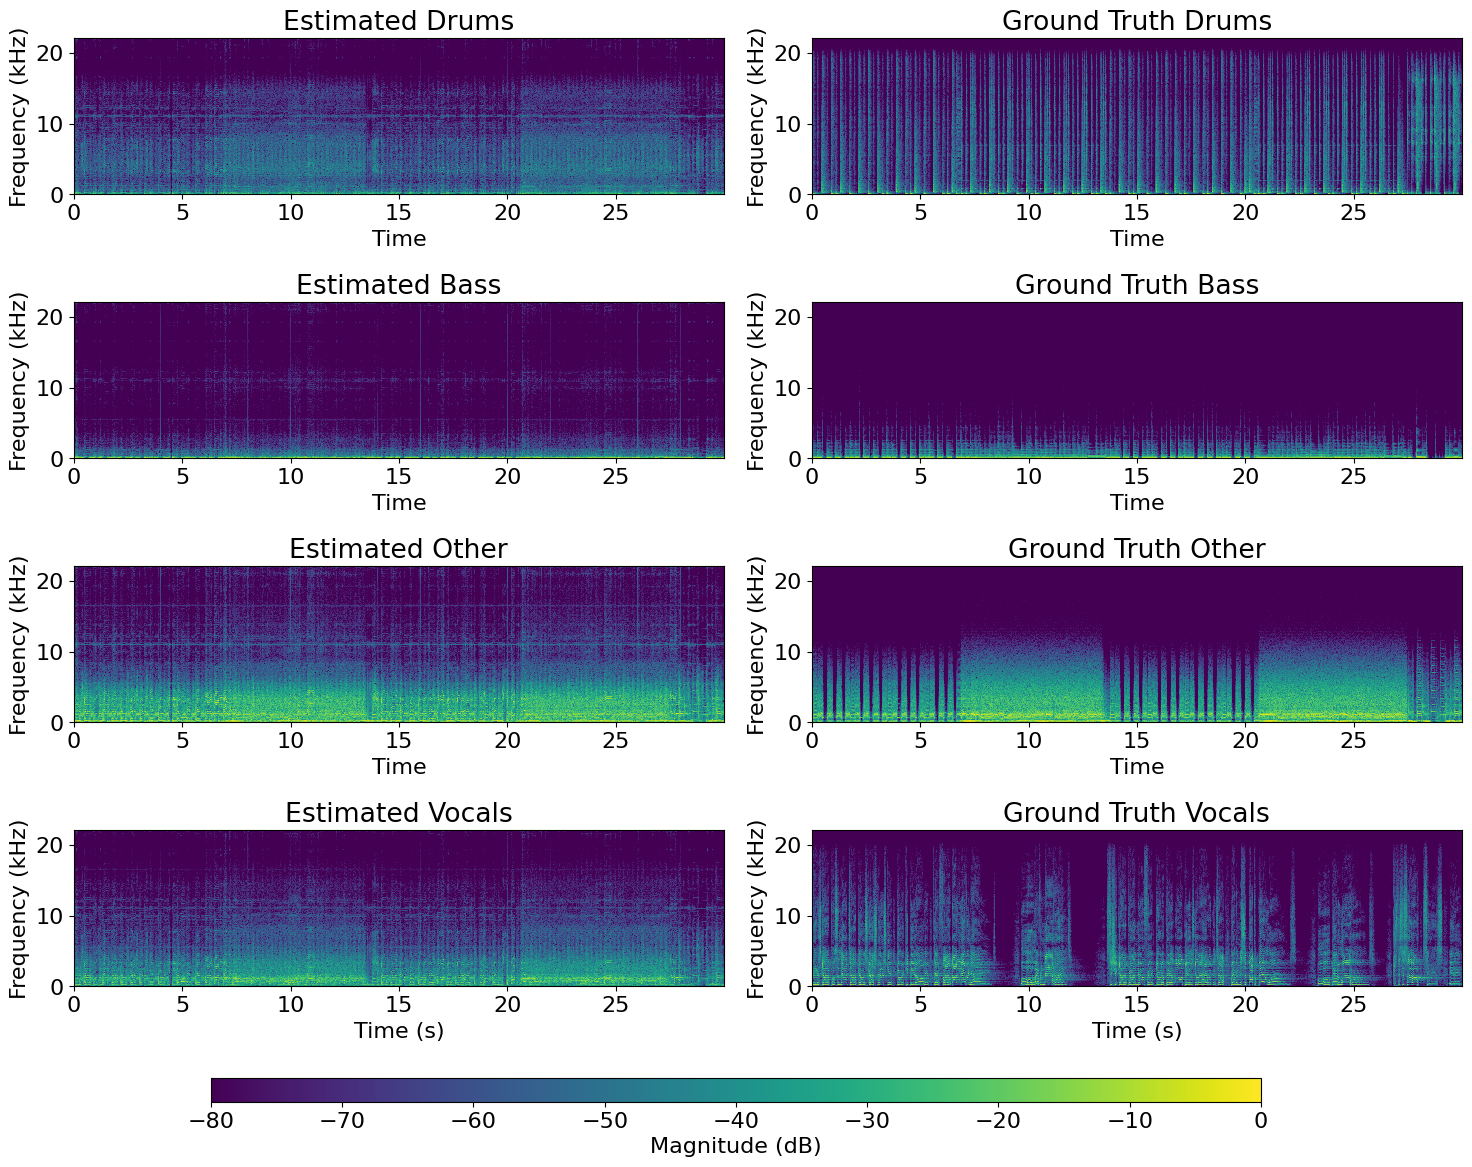

In [72]:
plot_spectrogram_comparison(list(dataset_dict.keys())[0], dataset_dict, separate_audio_sources_simple_demucs, duration=SEGMENT_LENGTH)  # Adjust duration as needed

In [73]:
sdr_simple_demucs, sar_simple_demucs, sir_simple_demucs = evaluate_metrics_across_dataset(
    separate_audio_sources_simple_demucs, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [15:14<00:00, 18.29s/it]


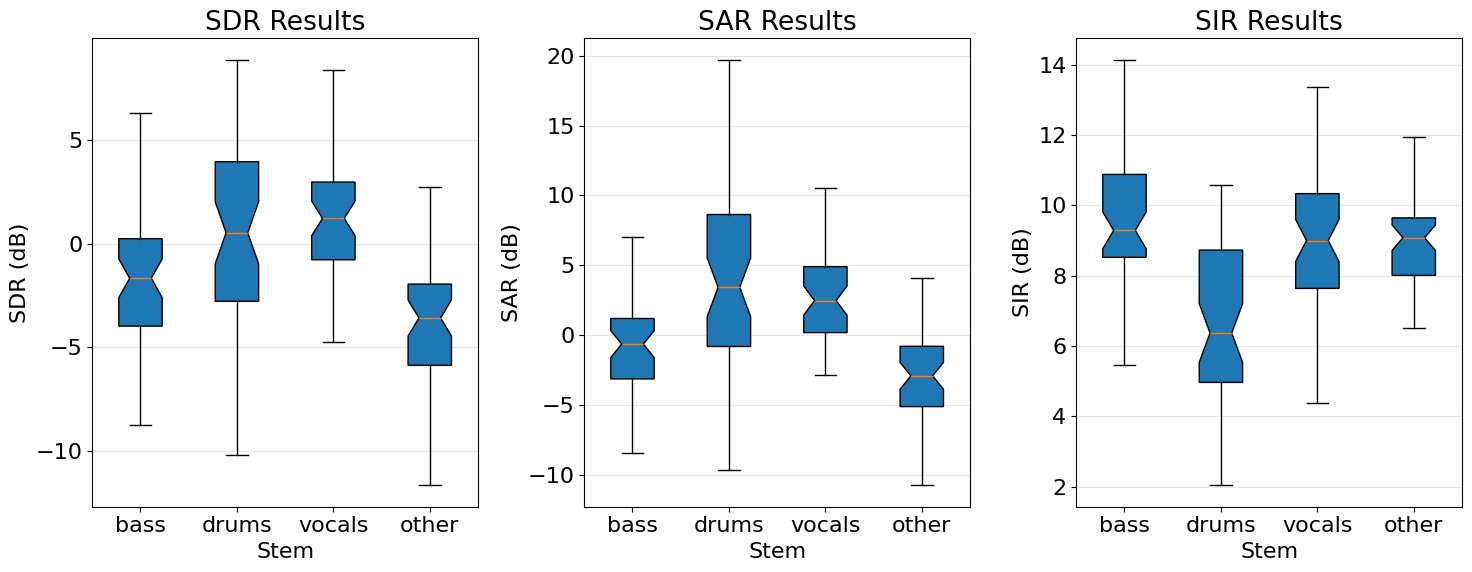

In [74]:
plot_metrics_results(sdr_simple_demucs, sar_simple_demucs, sir_simple_demucs)

In [ ]:
def find_best_sdr_per_stem_per_model(dataset_dict, *sdr_collections, model_names):
    """
    Find the highest SDR for each stem for each model.
    
    Args:
        dataset_dict: Dictionary containing the dataset with track names as keys
        *sdr_collections: Variable number of SDR collections from different models
        model_names: List of model names corresponding to the SDR collections
    
    Returns:
        dict: Dictionary with model names as keys and best SDR info for each stem
    """
    source_names = ["bass", "drums", "vocals", "other"]
    song_names = list(dataset_dict.keys())
    
    best_sdr_per_model = {}
    
    for model_idx, (sdr_collection, model_name) in enumerate(zip(sdr_collections, model_names)):
        best_sdr_per_model[model_name] = {}
        
        for stem_idx, stem_name in enumerate(source_names):
            best_sdr = -float('inf')
            best_song_idx = None
            best_song_name = None
            
            # Find best SDR for this stem in this model
            for song_idx in range(len(sdr_collection)):
                if song_idx < len(song_names):
                    current_sdr = sdr_collection[song_idx, stem_idx].item()
                    
                    if current_sdr > best_sdr:
                        best_sdr = current_sdr
                        best_song_idx = song_idx
                        best_song_name = song_names[song_idx]
            
            best_sdr_per_model[model_name][stem_name] = {
                'sdr': best_sdr,
                'song_index': best_song_idx,
                'song_name': best_song_name
            }
    
    return best_sdr_per_model

# Example usage
best_sdr_per_model = find_best_sdr_per_stem_per_model(
    dataset_dict,
    sar_hpps_repet, sdr_nnmf, sdr_unet, sdr_demucs, sdr_simple_demucs, 
    model_names=["REPET", "NNMF", 'UNet', 'Demucs', 'Simple Demucs']
)

# Display the best SDR results
for model_name, best_sdrs in best_sdr_per_model.items():
    print(f"\nBest SDR for {model_name}:")
    for stem_name, info in best_sdrs.items():
        print(f"  {stem_name.capitalize()}: {info['sdr']:.2f} dB (Song: {info['song_name']} at index {info['song_index']})")


def play_best_sdr_stems(best_sdr_per_model, dataset_dict):
    """
    Play the best SDR stems for each model using IPython.display.Audio.
    
    Args:
        best_sdr_per_model: Dictionary with model names as keys and best SDR info for each stem
        dataset_dict: Dictionary containing the dataset with track names as keys
    """
    from IPython.display import Audio, display
    import soundfile as sf
    import os
    import torch
    import numpy as np
    
    for model_name, best_sdrs in best_sdr_per_model.items():
        print(f"\nPlaying best SDR stems for {model_name}:")
        for stem_name, info in best_sdrs.items():
            song_name = info['song_name']
            song_data = dataset_dict[song_name][stem_name]
            
            # Convert tensor to numpy array if needed
            if isinstance(song_data, torch.Tensor):
                song_data_np = song_data.numpy()
            else:
                song_data_np = song_data
            
            print(f"  {stem_name.capitalize()} (SDR: {info['sdr']:.2f} dB) from {song_name}")
            display(Audio(song_data_np, rate=sample_rate, normalize=True))

            # save to file
            # Create directory for best SDR stems if it doesn't exist
            os.makedirs("best_sdr_stems", exist_ok=True)

            # Save the original stem
            original_filename = f"best_sdr_stems/{model_name}_{stem_name}_{song_name}_original.wav"
            # Ensure the audio data is in the correct format and shape
            if song_data_np.ndim > 1:
                # If stereo, take the first channel or average the channels
                if song_data_np.shape[0] == 2:  # Shape is (2, samples)
                    song_data_np = song_data_np.T  # Transpose to (samples, 2)
                elif song_data_np.shape[1] == 2:  # Shape is (samples, 2)
                    pass  # Already in correct format
                else:
                    song_data_np = song_data_np.flatten()  # Flatten to mono
            sf.write(original_filename, song_data_np, sample_rate, format='WAV', subtype='PCM_16')

            # use the functions separated_sources_demucs, separate_audio_sources_simple_demucs, separate_sources_nnmf, separate_sources_unet, separate_sources_repet
            # to separate the sources and play only the stems with the best SDR
            
            mixture_data = dataset_dict[song_name]["mixture"]
            if isinstance(mixture_data, torch.Tensor):
                mixture_data_np = mixture_data.numpy()
            else:
                mixture_data_np = mixture_data

            if model_name == "Demucs":
                separated_sources = separate_sources_demucs(mixture_data_np)
            elif model_name == "Simple Demucs":
                separated_sources = separate_audio_sources_simple_demucs(mixture_data_np)
            elif model_name == "NNMF":
                separated_sources = separate_sources_NNMF(mixture_data_np)
            elif model_name == "UNet":
                separated_sources = UNet_separate_music_sources(mixture_data_np)
            elif model_name == "REPET":
                separated_sources = separate_sources_HPSS_REPET(mixture_data_np)
            else:
                print(f"Model {model_name} not recognized for separation.")
                continue
            
            # Get the separated stem data
            best_stem_data = separated_sources[stem_name]
            
            # Convert tensor to numpy array if needed
            if isinstance(best_stem_data, torch.Tensor):
                best_stem_data = best_stem_data.numpy()
            
            # Play the best SDR stem
            display(Audio(best_stem_data, rate=sample_rate, normalize=True))
            
            # Save the separated stem
            separated_filename = f"best_sdr_stems/{model_name}_{stem_name}_{song_name}_separated.wav"
            # Ensure the audio data is in the correct format and shape
            if best_stem_data.ndim > 1:
                # If stereo, take the first channel or average the channels
                if best_stem_data.shape[0] == 2:  # Shape is (2, samples)
                    best_stem_data = best_stem_data.T  # Transpose to (samples, 2)
                elif best_stem_data.shape[1] == 2:  # Shape is (samples, 2)
                    pass  # Already in correct format
                else:
                    best_stem_data = best_stem_data.flatten()  # Flatten to mono
            sf.write(separated_filename, best_stem_data, sample_rate, format='WAV', subtype='PCM_16')
            
play_best_sdr_stems(best_sdr_per_model, dataset_dict)
